# **Configuration and Imports**

In [2]:
from google.colab import auth
auth.authenticate_user()


In [62]:
import dask.dataframe as dd
from dask_ml.preprocessing import StandardScaler, OneHotEncoder
from dask_ml.model_selection import train_test_split
from google.cloud import bigquery
import bigframes as bf
import bigframes.pandas as bpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils.multiclass import type_of_target
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_extraction import FeatureHasher
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from collections import Counter
from xgboost import XGBClassifier

In [4]:
project_id = "my-first-gcp-project-452814"
client = bigquery.Client(project=project_id)

print("Project ID:", client.project)


Project ID: my-first-gcp-project-452814


# **Datasets**
The datasets used in these project were the ones we considered most relevant for the task at hand.

They were uploaded to the BigQuery project `my-first-gcp-project-452814` via Google Cloud Storage.

Below we perform some queries to vizualize and ensure data quality in all of these the datasets.


## **Chartevents Reduced**
Contains time-stamped clinical data and measurements recorded for patients during their hospital stay.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `ITEMID`: Foreign key to the D_ITEMS table, indicating the type of measurement.
-   `CHARTTIME`: Timestamp when the measurement was recorded.
-   `STORETIME`: Timestamp when the measurement was stored.
-   `VALUE`: The value of the measurement (can be numeric or text).
-   `VALUENUM`: Numeric value of the measurement, if applicable.
-   `VALUEUOM`: Unit of measurement.
-   `WARNING`: Flags indicating potential issues with the data.


### **Reducing the original Chartevents dataset**

We decided to create a more small and acessible table using the original `chartevents`. This new table, `chartevents_reduced`, that will be used from now on, only contains the measurements of the most common disease in the original table.


In [ ]:
start_time = time.time()

query = """
-- Step 1: Create a new table for disease-related data
CREATE OR REPLACE TABLE `my-first-gcp-project-452814.cdle_project_dataset.chartevents_reduced` AS

-- Step 2: Identify and select only disease-related measurements
WITH disease_measurements AS (
  SELECT *
  FROM `my-first-gcp-project-452814.cdle_project_dataset.chartevents`
  WHERE ITEMID IN (
    -- Cardiovascular
    220045,  -- Heart Rate
    220050,  -- Blood Pressure Systolic
    220051,  -- Blood Pressure Diastolic

    -- Metabolic/Endocrine
    220179,  -- Glucose
    50912,   -- Creatinine
    50809,   -- Glucose (serum)

    -- Respiratory
    220277,  -- SpO2
    224690,  -- Respiratory Rate

    -- Infection/Inflammation
    50813,   -- Lactate (sepsis marker)

    -- Liver
    50821    -- Bilirubin
  )
),

-- Step 3: Find the top 3 most common disease measurements
top_disease_measurements AS (
  SELECT
    ITEMID,
    COUNT(*) AS measurement_count
  FROM disease_measurements
  GROUP BY ITEMID
  ORDER BY measurement_count DESC
  LIMIT 3
)

-- Step 4: Create final table with only top disease measurements
SELECT d.*
FROM disease_measurements d
JOIN top_disease_measurements t ON d.ITEMID = t.ITEMID;
"""

query_job = client.query(query)
print("Dataset reduced sucessfully")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

Dataset reduced sucessfully
Query Execution Time: 0.70 seconds


### **Visualization**

In [ ]:
start_time = time.time()

dataset_id = "cdle_project_dataset"
table_id = "chartevents_reduced"

table_ref = client.dataset(dataset_id).table(table_id)

chartevents = client.list_rows(table_ref).to_dataframe()

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

chartevents.head()

Query Execution Time: 7.32 seconds


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,19184847,66298,152072,200105,220045,2104-10-24 00:05:00+00:00,NaT,<NA>,0,0.0,bpm,0,0,None,None
1,24904858,79894,106711,201234,220045,2104-05-01 02:00:00+00:00,2104-05-01 02:10:00+00:00,16037,0,0.0,bpm,0,0,None,None
2,759709,9002,120994,203667,220045,2177-05-05 01:40:00+00:00,2177-05-05 01:48:00+00:00,18784,0,0.0,bpm,0,0,None,None
3,30895546,91558,119749,204020,220045,2183-09-01 09:10:00+00:00,2183-09-01 09:18:00+00:00,16526,0,0.0,bpm,0,0,None,None
4,34071445,99469,179324,204842,220179,2183-05-13 16:20:00+00:00,2183-05-13 17:10:00+00:00,19589,0,0.0,mmHg,0,0,None,None


### **Data quality check**

In [ ]:
start_time = time.time()

query = """
-- Data Quality Assessment for chartevents_reduced
WITH stats AS (
  SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT ITEMID) AS unique_measurement_types
  FROM `my-first-gcp-project-452814.cdle_project_dataset.chartevents_reduced`
),

measurement_analysis AS (
  SELECT
    ITEMID,
    COUNT(*) AS record_count,
    ROUND(COUNT(*)*100/(SELECT total_records FROM stats), 2) AS percentage_of_total,
    MIN(VALUENUM) AS min_value,
    MAX(VALUENUM) AS max_value,
    AVG(VALUENUM) AS avg_value,
    COUNT(CASE WHEN VALUENUM IS NULL THEN 1 END) AS null_value_counts,
    COUNT(CASE WHEN VALUE = '' THEN 1 END) AS empty_string_counts,
    MIN(CHARTTIME) AS earliest_measurement,
    MAX(CHARTTIME) AS latest_measurement
  FROM `my-first-gcp-project-452814.cdle_project_dataset.chartevents_reduced`
  GROUP BY ITEMID
),

temporal_analysis AS (
  SELECT
    EXTRACT(YEAR FROM CHARTTIME) AS year,
    EXTRACT(MONTH FROM CHARTTIME) AS month,
    COUNT(*) AS measurements_count
  FROM `my-first-gcp-project-452814.cdle_project_dataset.chartevents_reduced`
  GROUP BY year, month
  ORDER BY year, month
)

SELECT
  -- Basic Statistics
  s.total_records,
  s.unique_patients,
  s.unique_admissions,
  s.unique_measurement_types,

  -- Measurement-specific quality metrics
  ARRAY(
    SELECT AS STRUCT * FROM measurement_analysis
    ORDER BY record_count DESC
  ) AS measurement_quality,

  -- Temporal distribution
  (SELECT COUNT(*) FROM temporal_analysis) AS months_with_data,
  (SELECT MIN(year) FROM temporal_analysis) AS first_year,
  (SELECT MAX(year) FROM temporal_analysis) AS last_year,

  -- Data completeness
  (SELECT COUNT(*) FROM `my-first-gcp-project-452814.cdle_project_dataset.chartevents_reduced` WHERE CHARTTIME IS NULL) AS null_timestamps,
  (SELECT COUNT(*) FROM `my-first-gcp-project-452814.cdle_project_dataset.chartevents_reduced` WHERE SUBJECT_ID IS NULL) AS null_patient_ids,

  -- Clinical validity checks
  (SELECT COUNT(*) FROM `my-first-gcp-project-452814.cdle_project_dataset.chartevents_reduced`
   WHERE ITEMID = 220045 AND (VALUENUM < 20 OR VALUENUM > 250)) AS abnormal_heart_rates,

  (SELECT COUNT(*) FROM `my-first-gcp-project-452814.cdle_project_dataset.chartevents_reduced`
   WHERE ITEMID = 220050 AND (VALUENUM < 50 OR VALUENUM > 300)) AS abnormal_bp_readings
FROM stats s
"""

query_job = client.query(query)
data_quality = query_job.to_dataframe()

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

data_quality

Query Execution Time: 3.49 seconds


,total_records,unique_patients,unique_admissions,unique_measurement_types,measurement_quality,months_with_data,first_year,last_year,null_timestamps,null_patient_ids,abnormal_heart_rates,abnormal_bp_readings
0,6724529,17717,21927,3,"[{'ITEMID': 220045, 'record_count': 2762225, '...",1289,2100,2209,0,0,1177,0


## **Admissions**
Contains information about patient admissions to the hospital, such as admission and discharge times, admission type, and insurance information.

-   `ROW_ID`: Unique identifier for each row
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Unique identifier for the hospital admission
-   `ADMITTIME`: Timestamp for hospital admission.
-   `DISCHTIME`: Timestamp for hospital discharge.
-   `DEATHTIME`: Timestamp for patient death, if applicable.
-   `ADMISSION_TYPE`: Type of admission, e.g., EMERGENCY, ELECTIVE, URGENT.
-   `ADMISSION_LOCATION`: Location of the patient prior to admission.
-   `DISCHARGE_LOCATION`: Location to which the patient was discharged.
-   `INSURANCE`: The patient's insurance provider.
-   `LANGUAGE`: The patient's primary language.
-   `RELIGION`: The patient's religious affiliation.
-   `MARITAL_STATUS`: The patient's marital status.
-   `ETHNICITY`: The patient's ethnicity.
-   `EDREGTIME`: Emergency Department registration time
-   `EDOUTTIME`: Emergency Department departure time
-   `DIAGNOSIS`: The patient's primary diagnosis.
-   `HOSPITAL_EXPIRE_FLAG`: Indicates if the patient died in the hospital.
-   `HAS_CHARTEVENTS_DATA`: Flag indicating if there is chart event data.

### **Visualization**

In [ ]:
dataset_id = "cdle_project_dataset"
table_id = "Admissions"

table_ref = client.dataset(dataset_id).table(table_id)

admissions = client.list_rows(table_ref).to_dataframe()

admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,4060,3369,126808,2111-01-24 11:53:00+00:00,2111-01-25 22:40:00+00:00,2111-01-25 22:40:00+00:00,EMERGENCY,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,None,UNOBTAINABLE,SINGLE,WHITE,NaT,NaT,None,1,1
1,50952,74869,123152,2150-09-05 17:49:00+00:00,2150-09-12 18:30:00+00:00,2150-09-12 18:30:00+00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,ASIAN - JAPANESE,NaT,NaT,? SEROTONIN SYNDROME,1,1
2,12812,10484,113233,2190-09-18 22:39:00+00:00,2190-09-24 20:40:00+00:00,2190-09-24 20:40:00+00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicaid,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,(AML) ACUTE MYELOGENOUS LEUKEMIA,1,1
3,13573,11091,164694,2101-06-07 13:57:00+00:00,2101-09-18 07:20:00+00:00,2101-09-18 07:20:00+00:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,None,CATHOLIC,SEPARATED,WHITE,NaT,NaT,(AML) ACUTE MYELOGENOUS LEUKEMIA,1,1
4,33654,27527,155091,2131-08-27 18:01:00+00:00,2131-10-03 05:30:00+00:00,2131-10-03 05:30:00+00:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,PTUN,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,(AML) ACUTE MYELOGENOUS LEUKEMIA,1,1


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for admissions
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(CASE WHEN ADMITTIME IS NULL THEN 1 END) AS null_admit_times,
    COUNT(CASE WHEN DISCHTIME IS NULL THEN 1 END) AS null_discharge_times,
    COUNT(CASE WHEN ADMISSION_TYPE IS NULL THEN 1 END) AS null_admission_types,
    COUNT(CASE WHEN ADMISSION_LOCATION IS NULL THEN 1 END) AS null_admission_locations,
    COUNT(CASE WHEN INSURANCE IS NULL THEN 1 END) AS null_insurance_info,
    MIN(ADMITTIME) AS first_admission,
    MAX(ADMITTIME) AS last_admission
FROM `my-first-gcp-project-452814.cdle_project_dataset.Admissions`;
"""

query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_admissions,unique_patients,null_admit_times,null_discharge_times,null_admission_types,null_admission_locations,null_insurance_info,first_admission,last_admission
0,58976,58976,46520,0,0,0,0,0,2100-06-07 19:59:00+00:00,2210-08-17 17:13:00+00:00


## **Callout**

Contains information about requests for services or consultations for patients.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `CALLOUT_ID`: Unique identifier for the callout request.
-   `CALLOUTTIME`: Timestamp for the callout request.
-   `SERVICE_ID`: ID of the service requested.
-   `LOCATION`: Location of the patient when the callout was placed.
-   `STATUS`: Status of the callout request.
-   `OUTCOME`: Outcome of the callout request.
-   `ACKNOWLEDGE_TIME`: Timestamp when the callout was acknowledged.
-   `OUTCOMETIME`: Timestamp when the callout outcome was recorded.
-   `FIRSTRESERVATIONTIME`:  of the first reservation.
-   `CURRENTRESERVATIONTIME`: Timestamp of the current reservation.
-   `CREATETIME`: Timestamp when the row was created.
-   `UPDATETIME`: Timestamp when the row was updated.
-   `CALLOUT_WARDID`: Ward ID of the callout.
-   `CALLOUT_SERVICEREQUEST`: Service requested.
-   `CALLOUT_TELEPHONE`: Telephone number for the callout.
-    `REQUEST_TELE`: Telephone request.
-    `REQUEST_RESP`: Respiratory reqTimestampuest.
-   `REQUEST_CDIFF`: C. difficile request.
-   `REQUEST_MRSA`: MRSA request.
-   `REQUEST_VRE`: VRE request.
-   `DISCHARGE_WARDID`: Discharge ward ID.
-   `ACKNOWLEDGE_STATUS`: Acknowledge status.

### **Visualization**

In [ ]:
dataset_id = "cdle_project_dataset"
table_id = "Callout"

table_ref = client.dataset(dataset_id).table(table_id)

callout = client.list_rows(table_ref).to_dataframe()

callout.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SUBMIT_WARDID,SUBMIT_CAREUNIT,CURR_WARDID,CURR_CAREUNIT,CALLOUT_WARDID,CALLOUT_SERVICE,REQUEST_TELE,...,CALLOUT_STATUS,CALLOUT_OUTCOME,DISCHARGE_WARDID,ACKNOWLEDGE_STATUS,CREATETIME,UPDATETIME,ACKNOWLEDGETIME,OUTCOMETIME,FIRSTRESERVATIONTIME,CURRENTRESERVATIONTIME
0,15115,31974,144780,<NA>,None,<NA>,None,1,MED,1,...,Inactive,Discharged,0,Unacknowledged,2191-01-26 13:55:10+00:00,2191-01-26 13:55:10+00:00,NaT,2191-01-26 14:10:04+00:00,NaT,NaT
1,161,309,162308,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2160-06-05 10:22:04+00:00,2160-06-05 10:22:04+00:00,2160-06-05 11:20:06+00:00,2160-06-05 19:25:01+00:00,NaT,NaT
2,169,333,160548,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2137-09-30 09:42:12+00:00,2137-09-30 09:42:12+00:00,2137-09-30 09:45:08+00:00,2137-10-01 14:40:02+00:00,NaT,NaT
3,197,383,173723,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Unacknowledged,2143-09-08 10:53:04+00:00,2143-09-08 10:53:04+00:00,NaT,2143-09-08 11:55:02+00:00,NaT,NaT
4,136,253,176189,7,None,2,CCU,2,CCU,1,...,Inactive,Discharged,2,Acknowledged,2174-01-23 09:57:24+00:00,2174-01-23 10:44:12+00:00,2174-01-23 11:10:50+00:00,2174-01-23 13:40:02+00:00,NaT,NaT


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for callout
WITH basic_stats AS (
    SELECT
        COUNT(*) AS total_records,
        COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
        COUNT(DISTINCT HADM_ID) AS unique_admissions,
        COUNT(DISTINCT ROW_ID) AS unique_row_ids,
        COUNT(DISTINCT SUBMIT_WARDID) AS unique_submit_ward_ids,
        COUNT(DISTINCT SUBMIT_CAREUNIT) AS unique_submit_care_units,
        COUNT(DISTINCT CURR_WARDID) AS unique_current_ward_ids,
        COUNT(DISTINCT CURR_CAREUNIT) AS unique_current_care_units,
        COUNT(DISTINCT CALLOUT_WARDID) AS unique_callout_ward_ids,
        COUNT(DISTINCT CALLOUT_SERVICE) AS unique_callout_service,
        COUNT(DISTINCT REQUEST_TELE) AS unique_request_telephones,
        COUNT(DISTINCT REQUEST_RESP) AS unique_request_resp,
        COUNT(DISTINCT REQUEST_CDIFF) AS unique_request_cdiff,
        COUNT(DISTINCT REQUEST_MRSA) AS unique_request_mrsa,
        COUNT(DISTINCT REQUEST_VRE) AS unique_request_vre,
        COUNT(DISTINCT CALLOUT_STATUS) AS unique_callout_statuses,
        COUNT(DISTINCT CALLOUT_OUTCOME) AS unique_callout_outcomes,
        COUNT(DISTINCT DISCHARGE_WARDID) AS unique_discharge_ward_ids,
        COUNT(DISTINCT ACKNOWLEDGE_STATUS) AS unique_acknowledge_statuses
    FROM `my-first-gcp-project-452814.cdle_project_dataset.Callout`
),
completeness AS (
    SELECT
        COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
        COUNT(CASE WHEN HADM_ID IS NULL THEN 1 END) AS null_hadm_ids,
        COUNT(CASE WHEN SUBMIT_WARDID IS NULL THEN 1 END) AS null_submit_ward_ids,
        COUNT(CASE WHEN SUBMIT_CAREUNIT IS NULL THEN 1 END) AS null_submit_care_units,
        COUNT(CASE WHEN SUBMIT_CAREUNIT = '' THEN 1 END) AS empty_submit_care_units,
        COUNT(CASE WHEN CURR_WARDID IS NULL THEN 1 END) AS null_curr_ward_ids,
        COUNT(CASE WHEN CURR_CAREUNIT IS NULL THEN 1 END) AS null_curr_care_units,
        COUNT(CASE WHEN CURR_CAREUNIT = '' THEN 1 END) AS empty_curr_care_units,
        COUNT(CASE WHEN CALLOUT_WARDID IS NULL THEN 1 END) AS null_callout_ward_ids,
        COUNT(CASE WHEN CALLOUT_SERVICE IS NULL THEN 1 END) AS null_callout_service,
        COUNT(CASE WHEN CALLOUT_SERVICE = '' THEN 1 END) AS empty_callout_service,
        COUNT(CASE WHEN REQUEST_TELE IS NULL THEN 1 END) AS null_request_telephones,
        COUNT(CASE WHEN REQUEST_RESP IS NULL THEN 1 END) AS null_request_resp,
        COUNT(CASE WHEN REQUEST_CDIFF IS NULL THEN 1 END) AS null_request_cdiff,
        COUNT(CASE WHEN REQUEST_MRSA IS NULL THEN 1 END) AS null_request_mrsa,
        COUNT(CASE WHEN REQUEST_VRE IS NULL THEN 1 END) AS null_request_vre,
        COUNT(CASE WHEN CALLOUT_STATUS IS NULL THEN 1 END) AS null_callout_statuses,
        COUNT(CASE WHEN CALLOUT_STATUS = '' THEN 1 END) AS empty_callout_statuses,
        COUNT(CASE WHEN CALLOUT_OUTCOME IS NULL THEN 1 END) AS null_callout_outcomes,
        COUNT(CASE WHEN CALLOUT_OUTCOME = '' THEN 1 END) AS empty_callout_outcomes,
        COUNT(CASE WHEN DISCHARGE_WARDID IS NULL THEN 1 END) AS null_discharge_ward_ids,
        COUNT(CASE WHEN ACKNOWLEDGE_STATUS IS NULL THEN 1 END) AS null_acknowledge_statuses,
        COUNT(CASE WHEN ACKNOWLEDGE_STATUS = '' THEN 1 END) AS empty_acknowledge_statuses,
        COUNT(CASE WHEN CREATETIME IS NULL THEN 1 END) AS null_createtimes,
        COUNT(CASE WHEN UPDATETIME IS NULL THEN 1 END) AS null_updatetimes,
        COUNT(CASE WHEN ACKNOWLEDGETIME IS NULL THEN 1 END) AS null_acknowledgetimes,
        COUNT(CASE WHEN OUTCOMETIME IS NULL THEN 1 END) AS null_outcometimes,
        COUNT(CASE WHEN FIRSTRESERVATIONTIME IS NULL THEN 1 END) AS null_firstreservationtimes,
        COUNT(CASE WHEN CURRENTRESERVATIONTIME IS NULL THEN 1 END) AS null_currentreservationtimes
    FROM `my-first-gcp-project-452814.cdle_project_dataset.Callout`
),
temporal_analysis AS (
    SELECT
        MIN(CREATETIME) AS first_creation_time,
        MAX(CREATETIME) AS last_creation_time,
        MIN(UPDATETIME) AS first_update_time,
        MAX(UPDATETIME) AS last_update_time,
        MIN(ACKNOWLEDGETIME) AS first_acknowledge_time,
        MAX(ACKNOWLEDGETIME) AS last_acknowledge_time,
        MIN(OUTCOMETIME) AS first_outcome_time,
        MAX(OUTCOMETIME) AS last_outcome_time,
        MIN(FIRSTRESERVATIONTIME) AS first_reservation_time,
        MAX(FIRSTRESERVATIONTIME) AS last_reservation_time,
        MIN(CURRENTRESERVATIONTIME) AS first_current_reservation_time,
        MAX(CURRENTRESERVATIONTIME) AS last_current_reservation_time
    FROM `my-first-gcp-project-452814.cdle_project_dataset.Callout`
)
SELECT
    bs.*,
    c.*,
    t.*
FROM basic_stats bs
CROSS JOIN completeness c
CROSS JOIN temporal_analysis t;
"""

query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_patients,unique_admissions,unique_row_ids,unique_submit_ward_ids,unique_submit_care_units,unique_current_ward_ids,unique_current_care_units,unique_callout_ward_ids,unique_callout_service,...,first_update_time,last_update_time,first_acknowledge_time,last_acknowledge_time,first_outcome_time,last_outcome_time,first_reservation_time,last_reservation_time,first_current_reservation_time,last_current_reservation_time
0,34499,22871,28732,34499,9,5,35,5,37,21,...,2100-06-08 12:58:29+00:00,2210-08-20 16:05:16+00:00,2100-06-08 12:58:32+00:00,2210-08-20 16:05:27+00:00,2100-06-08 15:10:26+00:00,2210-08-20 18:55:15+00:00,2100-06-08 11:55:26+00:00,2210-08-20 16:25:16+00:00,2100-08-09 14:42:25+00:00,2209-08-05 14:01:23+00:00


## **ICD Diagnoses Description**
Contains descriptions for ICD-9 diagnosis codes.

-   `ROW_ID`: Unique identifier for the row.
-   `ICD9_CODE`: The ICD-9 diagnosis code.
-   `SHORT_TITLE`: Short description of the diagnosis.
-   `LONG_TITLE`: Long description of the diagnosis.

### **Visualization**

In [ ]:
dataset_id = "cdle_project_dataset"
table_id = "D_ICD_Diagnoses"

table_ref = client.dataset(dataset_id).table(table_id)

d_icd_diagnoses = client.list_rows(table_ref).to_dataframe()

d_icd_diagnoses.head()

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,5120,4957,"""ventilation"" pneumonit","""Ventilation"" pneumonitis"
1,11159,94416,1 deg burn back of hand,Erythema [first degree] of back of hand
2,11157,94414,1 deg burn fingr w thumb,Erythema [first degree] of two or more digits ...
3,3658,36911,1 eye-sev/oth-blind NOS,Better eye: severe vision impairment; lesser e...
4,12505,94811,10-19% bdy brn/10-19% 3d,Burn [any degree] involving 10-19 percent of b...


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for d_icd_diagnoses
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT ICD9_CODE) AS unique_icd9_codes,
    COUNT(DISTINCT SHORT_TITLE) AS unique_short_titles,
    COUNT(DISTINCT LONG_TITLE) AS unique_long_titles,

    -- Completeness checks
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN ICD9_CODE IS NULL THEN 1 END) AS null_icd9_codes,
    COUNT(CASE WHEN SHORT_TITLE IS NULL THEN 1 END) AS null_short_titles,
    COUNT(CASE WHEN LONG_TITLE IS NULL THEN 1 END) AS null_long_titles,

    COUNT(CASE WHEN ICD9_CODE = '' THEN 1 END) AS empty_icd9_codes,
    COUNT(CASE WHEN SHORT_TITLE = '' THEN 1 END) AS empty_short_titles,
    COUNT(CASE WHEN LONG_TITLE = '' THEN 1 END) AS empty_long_titles,

    -- Basic Analysis of ICD9 Code Length
    AVG(LENGTH(ICD9_CODE)) AS avg_icd9_code_length,
    MIN(LENGTH(ICD9_CODE)) AS min_icd9_code_length,
    MAX(LENGTH(ICD9_CODE)) AS max_icd9_code_length,
    COUNT(CASE WHEN LENGTH(ICD9_CODE) NOT BETWEEN 3 AND 5 THEN 1 END) AS potential_invalid_icd9_length_count,

    -- Potential data inconsistencies
    COUNT(CASE WHEN SHORT_TITLE LIKE '%NOS%' AND LONG_TITLE NOT LIKE '%not otherwise specified%' THEN 1 END) AS short_title_nos_long_title_mismatch,
    COUNT(CASE WHEN SHORT_TITLE LIKE '%NEC%' AND LONG_TITLE NOT LIKE '%not elsewhere classified%' THEN 1 END) AS short_title_nec_long_title_mismatch

FROM
    `my-first-gcp-project-452814.cdle_project_dataset.D_ICD_Diagnoses`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_icd9_codes,unique_short_titles,unique_long_titles,null_row_ids,null_icd9_codes,null_short_titles,null_long_titles,empty_icd9_codes,empty_short_titles,empty_long_titles,avg_icd9_code_length,min_icd9_code_length,max_icd9_code_length,potential_invalid_icd9_length_count,short_title_nos_long_title_mismatch,short_title_nec_long_title_mismatch
0,14567,14567,14567,14328,14562,0,0,0,0,0,0,0,4.686483,3,5,0,2195,2138


## **D Items**
Contains metadata about different medical items (measurements, procedures, medications) recorded in the database.

-   `ROW_ID`: Unique identifier for the row.
-   `ITEMID`: Unique identifier for the item.
-   `LABEL`: Label or name of the item.
-   `ABBREVIATION`: Abbreviation for the item.
-   `DBSOURCE`: Source database for the item.
-   `LINKSTO`: Table linked to.
-   `CATEGORY`: Category of the item.
-   `UNITNAME`: Unit of measurement for the item.
-   `PARAM_TYPE`: Parameter type.
-   `CONCEPTID`: Identifier for the concept.

### **Visualization**

In [ ]:
dataset_id = "cdle_project_dataset"
table_id = "D_Items"

table_ref = client.dataset(dataset_id).table(table_id)

d_items = client.list_rows(table_ref).to_dataframe()

d_items.head()

,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,457,497,Patient controlled analgesia (PCA) [Inject],None,carevue,chartevents,None,None,None,None
1,458,498,PCA Lockout (Min),None,carevue,chartevents,None,None,None,None
2,459,499,PCA Medication,None,carevue,chartevents,None,None,None,None
3,460,500,PCA Total Dose,None,carevue,chartevents,None,None,None,None
4,461,501,PCV Exh Vt (Obser),None,carevue,chartevents,None,None,None,None


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for d_items
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT ITEMID) AS unique_itemids,
    COUNT(DISTINCT LABEL) AS unique_labels,
    COUNT(DISTINCT ABBREVIATION) AS unique_abbreviations,
    COUNT(DISTINCT DBSOURCE) AS unique_dbsources,
    COUNT(DISTINCT LINKSTO) AS unique_linkstos,
    COUNT(DISTINCT CATEGORY) AS unique_categories,
    COUNT(DISTINCT UNITNAME) AS unique_unitnames,
    COUNT(DISTINCT PARAM_TYPE) AS unique_param_types,
    COUNT(DISTINCT CONCEPTID) AS unique_conceptids,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN ITEMID IS NULL THEN 1 END) AS null_itemids,
    COUNT(CASE WHEN LABEL IS NULL THEN 1 END) AS null_labels,
    COUNT(CASE WHEN ABBREVIATION IS NULL THEN 1 END) AS null_abbreviations,
    COUNT(CASE WHEN DBSOURCE IS NULL THEN 1 END) AS null_dbsources,
    COUNT(CASE WHEN LINKSTO IS NULL THEN 1 END) AS null_linkstos,
    COUNT(CASE WHEN CATEGORY IS NULL THEN 1 END) AS null_categories,
    COUNT(CASE WHEN UNITNAME IS NULL THEN 1 END) AS null_unitnames,
    COUNT(CASE WHEN PARAM_TYPE IS NULL THEN 1 END) AS null_param_types,
    COUNT(CASE WHEN CONCEPTID IS NULL THEN 1 END) AS null_conceptids,

    -- Completeness checks (Empty strings)
    COUNT(CASE WHEN LABEL = '' THEN 1 END) AS empty_labels,
    COUNT(CASE WHEN ABBREVIATION = '' THEN 1 END) AS empty_abbreviations,
    COUNT(CASE WHEN DBSOURCE = '' THEN 1 END) AS empty_dbsources,
    COUNT(CASE WHEN LINKSTO = '' THEN 1 END) AS empty_linkstos,
    COUNT(CASE WHEN CATEGORY = '' THEN 1 END) AS empty_categories,
    COUNT(CASE WHEN UNITNAME = '' THEN 1 END) AS empty_unitnames,
    COUNT(CASE WHEN PARAM_TYPE = '' THEN 1 END) AS empty_param_types,
    COUNT(CASE WHEN CONCEPTID = '' THEN 1 END) AS empty_conceptids

FROM
    `my-first-gcp-project-452814.cdle_project_dataset.D_Items`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_itemids,unique_labels,unique_abbreviations,unique_dbsources,unique_linkstos,unique_categories,unique_unitnames,unique_param_types,...,null_param_types,null_conceptids,empty_labels,empty_abbreviations,empty_dbsources,empty_linkstos,empty_categories,empty_unitnames,empty_param_types,empty_conceptids
0,12487,12487,12487,11847,2907,3,7,94,53,7,...,9495,12487,0,0,0,0,0,0,0,0


## **ICD Diagnoses**
Contains ICD-9 diagnosis codes assigned to patients during their hospital admissions.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `SEQ_NUM`: Sequence number for the diagnosis within the admission.
-   `ICD9_CODE`: The ICD-9 diagnosis code.


### **Visualization**

In [ ]:
dataset_id = "cdle_project_dataset"
table_id = "Diagnoses_ICD"

table_ref = client.dataset(dataset_id).table(table_id)

diagnoses_icd = client.list_rows(table_ref).to_dataframe()

diagnoses_icd.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1,40301
1,1298,109,172335,2,486
2,1299,109,172335,3,58281
3,1300,109,172335,4,5855
4,1301,109,172335,5,4254


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for diagnoses_icd
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT SEQ_NUM) AS unique_sequence_numbers,
    COUNT(DISTINCT ICD9_CODE) AS unique_icd9_codes,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
    COUNT(CASE WHEN HADM_ID IS NULL THEN 1 END) AS null_hadm_ids,
    COUNT(CASE WHEN SEQ_NUM IS NULL THEN 1 END) AS null_sequence_numbers,
    COUNT(CASE WHEN ICD9_CODE IS NULL THEN 1 END) AS null_icd9_codes,

    -- Completeness checks (Empty strings)
    COUNT(CASE WHEN ICD9_CODE = '' THEN 1 END) AS empty_icd9_codes,

    -- Analysis of ICD9 Code Length
    AVG(LENGTH(ICD9_CODE)) AS avg_icd9_code_length,
    MIN(LENGTH(ICD9_CODE)) AS min_icd9_code_length,
    MAX(LENGTH(ICD9_CODE)) AS max_icd9_code_length,
    COUNT(CASE WHEN LENGTH(ICD9_CODE) NOT BETWEEN 3 AND 5 THEN 1 END) AS potential_invalid_icd9_length_count

FROM
    `my-first-gcp-project-452814.cdle_project_dataset.Diagnoses_ICD`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_patients,unique_admissions,unique_sequence_numbers,unique_icd9_codes,null_row_ids,null_subject_ids,null_hadm_ids,null_sequence_numbers,null_icd9_codes,empty_icd9_codes,avg_icd9_code_length,min_icd9_code_length,max_icd9_code_length,potential_invalid_icd9_length_count
0,651047,651047,46520,58976,39,6984,0,0,0,47,47,0,4.448883,3,5,0


## **Icustays**
Contains information about patient stays in the intensive care unit (ICU).

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Foreign key to the PATIENTS table.
-   `HADM_ID`: Foreign key to the ADMISSIONS table.
-   `ICUSTAY_ID`: Unique identifier for the ICU stay.
-   `DBSOURCE`: Source database.
-   `FIRST_CAREUNIT`: First care unit the patient was in.
-   `LAST_CAREUNIT`: Last care unit the patient was in.
-   `FIRST_WARDID`: First ward ID.
-   `LAST_WARDID`: Last ward ID.
-   `INTIME`: Timestamp for ICU admission.
-   `OUTTIME`: Timestamp for ICU discharge.
-   `LOS`: Length of ICU stay.


### **Visualization**

In [ ]:
dataset_id = "cdle_project_dataset"
table_id = "ICUStays"

table_ref = client.dataset(dataset_id).table(table_id)

icustays = client.list_rows(table_ref).to_dataframe()

icustays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,372,275,129886,219649,carevue,CCU,CCU,7,7,2170-10-07 11:28:53+00:00,2170-10-14 14:38:07+00:00,7.1314
1,389,291,113649,256641,carevue,CCU,CCU,7,7,2102-04-08 23:05:28+00:00,2102-04-09 11:20:11+00:00,0.5102
2,390,291,125726,275109,metavision,CCU,CCU,7,7,2106-04-17 12:26:17+00:00,2106-04-18 22:05:39+00:00,1.4023
3,394,294,152578,222074,carevue,CCU,CCU,7,7,2118-01-17 21:45:05+00:00,2118-01-20 11:12:45+00:00,2.5609
4,401,301,160332,288401,carevue,CCU,CCU,7,7,2189-11-11 12:12:33+00:00,2189-11-13 22:11:28+00:00,2.4159


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for icustays
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT HADM_ID) AS unique_admissions,
    COUNT(DISTINCT ICUSTAY_ID) AS unique_icustay_ids,
    COUNT(DISTINCT DBSOURCE) AS unique_dbsources,
    COUNT(DISTINCT FIRST_CAREUNIT) AS unique_first_careunits,
    COUNT(DISTINCT LAST_CAREUNIT) AS unique_last_careunits,
    COUNT(DISTINCT FIRST_WARDID) AS unique_first_wardids,
    COUNT(DISTINCT LAST_WARDID) AS unique_last_wardids,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
    COUNT(CASE WHEN HADM_ID IS NULL THEN 1 END) AS null_hadm_ids,
    COUNT(CASE WHEN ICUSTAY_ID IS NULL THEN 1 END) AS null_icustay_ids,
    COUNT(CASE WHEN DBSOURCE IS NULL THEN 1 END) AS null_dbsources,
    COUNT(CASE WHEN FIRST_CAREUNIT IS NULL THEN 1 END) AS null_first_careunits,
    COUNT(CASE WHEN LAST_CAREUNIT IS NULL THEN 1 END) AS null_last_careunits,
    COUNT(CASE WHEN FIRST_WARDID IS NULL THEN 1 END) AS null_first_wardids,
    COUNT(CASE WHEN LAST_WARDID IS NULL THEN 1 END) AS null_last_wardids,
    COUNT(CASE WHEN INTIME IS NULL THEN 1 END) AS null_intimes,
    COUNT(CASE WHEN OUTTIME IS NULL THEN 1 END) AS null_outtimes,
    COUNT(CASE WHEN LOS IS NULL THEN 1 END) AS null_los,

    -- Completeness checks (Empty strings)
    COUNT(CASE WHEN FIRST_CAREUNIT = '' THEN 1 END) AS empty_first_careunits,
    COUNT(CASE WHEN LAST_CAREUNIT = '' THEN 1 END) AS empty_last_careunits,
    COUNT(CASE WHEN DBSOURCE = '' THEN 1 END) AS empty_dbsources,

    -- Basic Analysis of LOS (Length of ICU Stay)
    AVG(LOS) AS avg_los,
    MIN(LOS) AS min_los,
    MAX(LOS) AS max_los,
    COUNT(CASE WHEN LOS < 0 THEN 1 END) AS negative_los_count -- Potential data issue

FROM
    `my-first-gcp-project-452814.cdle_project_dataset.ICUStays`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_patients,unique_admissions,unique_icustay_ids,unique_dbsources,unique_first_careunits,unique_last_careunits,unique_first_wardids,unique_last_wardids,...,null_intimes,null_outtimes,null_los,empty_first_careunits,empty_last_careunits,empty_dbsources,avg_los,min_los,max_los,negative_los_count
0,61532,61532,46476,57786,61532,3,6,6,16,17,...,0,10,10,0,0,0,4.917972,0.0001,173.0725,0


## **Patients**
Contains demographic information about the patients in the database.

-   `ROW_ID`: Unique identifier for the row.
-   `SUBJECT_ID`: Unique identifier for the patient.
-   `GENDER`: Patient's gender.
-   `DOB`: Patient's date of birth.
-   `DOD`: Patient's date of death, if applicable.
-   `DOD_HOSP`: Date of death in hospital.
-   `DOD_SSN`: Date of death according to Social Security records.
-   `EXPIRE_FLAG`: Flag indicating if the patient expired.

### **Visualization**

In [ ]:
dataset_id = "cdle_project_dataset"
table_id = "Patients"

table_ref = client.dataset(dataset_id).table(table_id)

patients = client.list_rows(table_ref).to_dataframe()

patients.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00+00:00,NaT,NaT,NaT,0
1,238,253,F,2089-11-26 00:00:00+00:00,NaT,NaT,NaT,0
2,242,258,F,2124-09-19 00:00:00+00:00,NaT,NaT,NaT,0
3,243,260,F,2105-03-23 00:00:00+00:00,NaT,NaT,NaT,0
4,247,264,F,2162-11-30 00:00:00+00:00,NaT,NaT,NaT,0


### **Data quality check**

In [ ]:
query = """
-- Data Quality Assessment for patients
SELECT
    COUNT(*) AS total_records,
    COUNT(DISTINCT ROW_ID) AS unique_row_ids,
    COUNT(DISTINCT SUBJECT_ID) AS unique_patients,
    COUNT(DISTINCT GENDER) AS unique_genders,
    COUNT(DISTINCT DOB) AS unique_dates_of_birth,
    COUNT(DISTINCT DOD) AS unique_dates_of_death,
    COUNT(DISTINCT DOD_HOSP) AS unique_dates_of_death_hospital,
    COUNT(DISTINCT DOD_SSN) AS unique_dates_of_death_ssn,
    COUNT(DISTINCT EXPIRE_FLAG) AS unique_expire_flags,

    -- Completeness checks (NULL values)
    COUNT(CASE WHEN ROW_ID IS NULL THEN 1 END) AS null_row_ids,
    COUNT(CASE WHEN SUBJECT_ID IS NULL THEN 1 END) AS null_subject_ids,
    COUNT(CASE WHEN GENDER IS NULL THEN 1 END) AS null_genders,
    COUNT(CASE WHEN DOB IS NULL THEN 1 END) AS null_dates_of_birth,
    COUNT(CASE WHEN DOD IS NULL THEN 1 END) AS null_dates_of_death,
    COUNT(CASE WHEN DOD_HOSP IS NULL THEN 1 END) AS null_dates_of_death_hospital,
    COUNT(CASE WHEN DOD_SSN IS NULL THEN 1 END) AS null_dates_of_death_ssn,
    COUNT(CASE WHEN EXPIRE_FLAG IS NULL THEN 1 END) AS null_expire_flags,

    -- Completeness checks (Empty strings)
    COUNT(CASE WHEN GENDER = '' THEN 1 END) AS empty_genders,

    -- Basic Analysis of Dates
    MIN(DOB) AS first_dob,
    MAX(DOB) AS last_dob,
    MIN(DOD) AS first_dod,
    MAX(DOD) AS last_dod,

    -- Potential Data Inconsistencies
    COUNT(CASE WHEN DOD IS NOT NULL AND EXPIRE_FLAG = 0 THEN 1 END) AS died_but_not_expired_flag,
    COUNT(CASE WHEN DOD IS NULL AND EXPIRE_FLAG = 1 THEN 1 END) AS expired_flag_but_no_dod

FROM
    `my-first-gcp-project-452814.cdle_project_dataset.Patients`;
"""
query_job = client.query(query)
data_quality = query_job.to_dataframe()
data_quality

,total_records,unique_row_ids,unique_patients,unique_genders,unique_dates_of_birth,unique_dates_of_death,unique_dates_of_death_hospital,unique_dates_of_death_ssn,unique_expire_flags,null_row_ids,...,null_dates_of_death_hospital,null_dates_of_death_ssn,null_expire_flags,empty_genders,first_dob,last_dob,first_dod,last_dod,died_but_not_expired_flag,expired_flag_but_no_dod
0,46520,46520,46520,2,32540,12911,8747,11301,2,0,...,36546,33142,0,0,1800-07-02 00:00:00+00:00,2201-07-24 00:00:00+00:00,2100-06-19 00:00:00+00:00,2211-06-10 00:00:00+00:00,0,0


# **Junction of tables**
To make the pre-processing and Length of ICU Stay prediction more efficient we decided to create a table, using a querie, that contain the most relevant columns of each of the datasets.

The most relevant columns choosen were:
- Patient Info: `SUBJECT_ID`, `GENDER`, `DOB`, `EXPIRE_FLAG`, `AGE_AT_ADMISSION`
- Admission Info: `HADM_ID`, `ADMITTIME`, `DISCHTIME`, `ADMISSION_TYPE`, `ADMISSION_LOCATION`, `INSURANCE`, `ETHNICITY`, `ADMISSION_DIAGNOSIS_TEXT`, `ADMISSION_HOUR`
- ICU Stay Info: `ICUSTAY_ID, ICU_INTIME`, `ICU_OUTTIME`, `ICU_LOS` (Target), `FIRST_CAREUNIT`
- Diagnosis Info: `PRIMARY_ICD9_CODE`, `PRIMARY_ICD9_TITLE`
- Callout Info: `NUM_CALLOUTS`

In [ ]:
query = """
-- Creating a junction table with aggregated diagnoses, callouts and engineered features

CREATE OR REPLACE TABLE `my-first-gcp-project-452814.cdle_project_dataset.junction_table` AS

-- Define CTEs within the AS clause
WITH
  -- CTE to select only the primary diagnosis for each hospital admission
  PrimaryDiagnosis AS (
    SELECT
      di.HADM_ID,
      di.ICD9_CODE,
      dd.SHORT_TITLE AS ICD9_SHORT_TITLE
    FROM
      `my-first-gcp-project-452814.cdle_project_dataset.Diagnoses_ICD` AS di
    LEFT JOIN
      `my-first-gcp-project-452814.cdle_project_dataset.D_ICD_Diagnoses` AS dd ON di.ICD9_CODE = dd.ICD9_CODE
    WHERE
      di.SEQ_NUM = 1 -- Filter for primary diagnosis only
  ),

  -- CTE to count the number of callouts for each hospital admission
  CalloutCount AS (
    SELECT
      HADM_ID,
      COUNT(*) AS NUM_CALLOUTS -- Count callouts per admission
    FROM
      `my-first-gcp-project-452814.cdle_project_dataset.Callout`
    GROUP BY
      HADM_ID
  )

-- Main SELECT statement that uses the CTEs
SELECT
    -- Patient demographics & calculated age
    p.SUBJECT_ID,
    p.GENDER,
    p.DOB,
    p.EXPIRE_FLAG,
    DATE_DIFF(DATE(a.ADMITTIME), DATE(p.DOB), YEAR) AS AGE_AT_ADMISSION, -- Calculate age

    -- Admission details & extracted features
    a.HADM_ID,
    a.ADMITTIME,
    a.DISCHTIME,
    a.ADMISSION_TYPE,
    a.ADMISSION_LOCATION,
    a.INSURANCE,
    a.ETHNICITY,
    a.DIAGNOSIS AS ADMISSION_DIAGNOSIS_TEXT,
    EXTRACT(HOUR FROM a.ADMITTIME) AS ADMISSION_HOUR,

    -- ICU stay details (TARGET VARIABLE HERE)
    icu.ICUSTAY_ID,
    icu.INTIME AS ICU_INTIME,
    icu.OUTTIME AS ICU_OUTTIME,
    icu.LOS AS ICU_LOS,           -- TARGET VARIABLE
    icu.FIRST_CAREUNIT,

    -- Primary Diagnosis details (from CTE)
    pd.ICD9_CODE AS PRIMARY_ICD9_CODE,
    pd.ICD9_SHORT_TITLE AS PRIMARY_ICD9_TITLE,

    -- Aggregated Callout details (from CTE)
    cc.NUM_CALLOUTS

FROM
    -- Start with patients table
    `my-first-gcp-project-452814.cdle_project_dataset.Patients` AS p
LEFT JOIN
    -- Join with admissions using SUBJECT_ID
    `my-first-gcp-project-452814.cdle_project_dataset.Admissions` AS a ON p.SUBJECT_ID = a.SUBJECT_ID
LEFT JOIN
    -- Join with ICU stays using HADM_ID
    `my-first-gcp-project-452814.cdle_project_dataset.ICUStays` AS icu ON a.HADM_ID = icu.HADM_ID
LEFT JOIN
    -- Join with pre-filtered primary diagnosis using HADM_ID
    PrimaryDiagnosis AS pd ON a.HADM_ID = pd.HADM_ID
LEFT JOIN
    -- Join with pre-aggregated callout counts using HADM_ID
    CalloutCount AS cc ON a.HADM_ID = cc.HADM_ID


"""

query_job = client.query(query)
query_job.result()

### **Visualization**

In [ ]:
dataset_id = "cdle_project_dataset"
table_id = "junction_table"

table_ref = client.dataset(dataset_id).table(table_id)

junction_table = client.list_rows(table_ref).to_dataframe()

junction_table.head()

,SUBJECT_ID,GENDER,DOB,EXPIRE_FLAG,AGE_AT_ADMISSION,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,...,ADMISSION_DIAGNOSIS_TEXT,ADMISSION_HOUR,ICUSTAY_ID,ICU_INTIME,ICU_OUTTIME,ICU_LOS,FIRST_CAREUNIT,PRIMARY_ICD9_CODE,PRIMARY_ICD9_TITLE,NUM_CALLOUTS
0,21852,M,2079-10-15 00:00:00+00:00,1,54,144317,2133-06-02 05:09:00+00:00,2133-06-02 03:14:00+00:00,EMERGENCY,** INFO NOT AVAILABLE **,...,CARDIAC ARREST,5,251228,2133-06-02 05:10:11+00:00,2133-06-02 05:10:27+00:00,0.0002,CSRU,4271,Parox ventric tachycard,<NA>
1,19082,F,1869-10-30 00:00:00+00:00,1,300,187326,2169-10-30 04:28:00+00:00,2169-11-06 19:45:00+00:00,EMERGENCY,** INFO NOT AVAILABLE **,...,"RESPIRATORY FAILURE,UROSEPSIS",4,263042,2169-10-30 04:29:22+00:00,2169-11-03 15:29:54+00:00,4.4587,MICU,51881,Acute respiratry failure,1
2,23493,M,2103-04-03 00:00:00+00:00,0,0,127281,2103-04-03 09:25:00+00:00,2103-04-08 12:17:00+00:00,NEWBORN,** INFO NOT AVAILABLE **,...,NEWBORN,9,252466,2103-04-03 09:36:42+00:00,2103-04-03 22:29:06+00:00,0.5364,NICU,76519,Preterm NEC 2500+g,<NA>
3,20778,F,2105-09-02 00:00:00+00:00,1,75,113683,2180-12-02 17:46:00+00:00,2180-12-11 19:21:00+00:00,EMERGENCY,** INFO NOT AVAILABLE **,...,ANKLE FRACTURE,17,260515,2180-12-05 16:40:35+00:00,2180-12-06 17:48:37+00:00,1.0472,MICU,8244,Fx bimalleolar-closed,1
4,13647,M,2081-12-22 00:00:00+00:00,0,27,143439,2108-12-17 01:53:00+00:00,2108-12-23 13:00:00+00:00,EMERGENCY,** INFO NOT AVAILABLE **,...,GUN SHOT WOUND,1,292926,2108-12-17 02:40:14+00:00,2108-12-18 18:06:51+00:00,1.6435,TSICU,86349,Colon injury NEC-closed,<NA>


# **Data Pre-Processing - Dask**
In this section of the project, we will use **Dask** to perform some pre-processing on the `junction_table`, to deal with repeated rows and null values

## **Duplicate Rows Analysis**

In [5]:
dtype = {
    "SUBJECT_ID": "float64",
    "GENDER": "object",
    "DOB": "object",
    "EXPIRE_FLAG": "float64",
    "AGE_AT_ADMISSION": "float64",
    "HADM_ID": "float64",
    "ADMITTIME": "object",
    "DISCHTIME": "object",
    "ADMISSION_TYPE": "object",
    "ADMISSION_LOCATION": "object",
    "INSURANCE": "object",
    "ETHNICITY": "object",
    "ADMISSION_DIAGNOSIS_TEXT": "object",
    "ADMISSION_HOUR": "float64",
    "ICUSTAY_ID": "float64",
    "ICU_INTIME": "object",
    "ICU_OUTTIME": "object",
    "ICU_LOS": "float64",
    "FIRST_CAREUNIT": "object",
    "PRIMARY_ICD9_CODE": "object",
    "PRIMARY_ICD9_TITLE": "object",
    "NUM_CALLOUTS": "float64"
}

ddf = dd.read_csv('gs://n_cdle_project/junction_table', dtype=dtype)

In [6]:
print(ddf.dtypes)

SUBJECT_ID                          float64
GENDER                      string[pyarrow]
DOB                         string[pyarrow]
EXPIRE_FLAG                         float64
AGE_AT_ADMISSION                    float64
HADM_ID                             float64
ADMITTIME                   string[pyarrow]
DISCHTIME                   string[pyarrow]
ADMISSION_TYPE              string[pyarrow]
ADMISSION_LOCATION          string[pyarrow]
INSURANCE                   string[pyarrow]
ETHNICITY                   string[pyarrow]
ADMISSION_DIAGNOSIS_TEXT    string[pyarrow]
ADMISSION_HOUR                      float64
ICUSTAY_ID                          float64
ICU_INTIME                  string[pyarrow]
ICU_OUTTIME                 string[pyarrow]
ICU_LOS                             float64
FIRST_CAREUNIT              string[pyarrow]
PRIMARY_ICD9_CODE           string[pyarrow]
PRIMARY_ICD9_TITLE          string[pyarrow]
NUM_CALLOUTS                        float64
dtype: object


In [8]:
start_time = time.time()

# Group by ICUSTAY_ID and count number of rows
result_ddf = (
    ddf.groupby("ICUSTAY_ID")
       .size()
       .to_frame("number_of_rows")      # convert to DataFrame and name the count column
       .reset_index()                   # reset index to make ICUSTAY_ID a column again
       .query("number_of_rows > 1")
       .sort_values("number_of_rows", ascending=False)
)

# Compute the result
results = result_ddf.compute()

# Print results
print("ICUSTAY_ID | number_of_rows")
print("-----------------------------")
for _, row in results.iterrows():
    print(f"{row['ICUSTAY_ID']} | {row['number_of_rows']}")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

ICUSTAY_ID | number_of_rows
-----------------------------
Query Execution Time: 0.90 seconds


### **Conclusion**
Based on the results of the query, we can conclude that besides the rows that contain the value `None` that are not any duplicate rows.

## **Null Values Analysis**

In [10]:
start_time = time.time()

# Total number of rows
total_rows = ddf.shape[0].compute()

# Count of nulls per column
null_counts = ddf.isna().sum().compute()

# Percentage of nulls per column
null_percentages = (null_counts / total_rows * 100).round(2)

# Combine into a single transposed DataFrame for display
null_analysis_df = pd.DataFrame({
    'null_count': null_counts,
    'null_percentage': null_percentages
}).T

print(f"Total number of rows: {total_rows}")
print("🔍 Null Value Analysis (Transposed View):")
print(null_analysis_df)

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

Total number of rows: 62722
🔍 Null Value Analysis (Transposed View):
                 SUBJECT_ID  GENDER  DOB  EXPIRE_FLAG  AGE_AT_ADMISSION  \
null_count              0.0     0.0  0.0          0.0               0.0   
null_percentage         0.0     0.0  0.0          0.0               0.0   

                 HADM_ID  ADMITTIME  DISCHTIME  ADMISSION_TYPE  \
null_count           0.0        0.0        0.0             0.0   
null_percentage      0.0        0.0        0.0             0.0   

                 ADMISSION_LOCATION  ...  ADMISSION_DIAGNOSIS_TEXT  \
null_count                      0.0  ...                     25.00   
null_percentage                 0.0  ...                      0.04   

                 ADMISSION_HOUR  ICUSTAY_ID  ICU_INTIME  ICU_OUTTIME  ICU_LOS  \
null_count                  0.0      1190.0      1190.0      1200.00  1200.00   
null_percentage             0.0         1.9         1.9         1.91     1.91   

                 FIRST_CAREUNIT  PRIMARY_ICD9_CODE 

### **Conclusion**
There are 62722 rows. The core patient and admission data is complete. However, approximately 1.9% of rows have nulls for ICU-related features, including the target variable `ICU_LOS`, primarily representing non-ICU admissions or missing discharge times. The primary diagnosis title has minor missingness (~1.3%). The biggest problem is the `NUM_CALLOUTS` feature, that has a high null rate (50%), requiring specific handling.

### **Approach to Missing Values in** `NUM_CALLOUTS`
Knowing that the feature `NUM_CALLOUTS` is not too essential to predict the lenght of stay, we will remove this column from the table to avoid future processing problems.

In [11]:
ddf = ddf.drop(columns=["NUM_CALLOUTS"])

### **Approach to other Missing Values**
Knowing that the rows with missing values in other columns, including the target column `ICU_LOS` represent a very small percentage of the dataset, we decided the simplest and most effective solution would be to remove these rows.

In [12]:
ddf = ddf.dropna()

### **Running the Null Values Query again**
In order to assess if our changes were sucessful, we decided to run the Null Values query again.

In [14]:
start_time = time.time()

# Total number of rows
total_rows = ddf.shape[0].compute()

# Count of nulls per column
null_counts = ddf.isna().sum().compute()

# Percentage of nulls per column
null_percentages = (null_counts / total_rows * 100).round(2)

# Combine into a single transposed DataFrame for display
null_analysis_df = pd.DataFrame({
    'null_count': null_counts,
    'null_percentage': null_percentages
}).T

print(f"Total number of rows: {total_rows}")
print("🔍 Null Value Analysis (Transposed View):")
print(null_analysis_df)

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

Total number of rows: 60748
🔍 Null Value Analysis (Transposed View):
                 SUBJECT_ID  GENDER  DOB  EXPIRE_FLAG  AGE_AT_ADMISSION  \
null_count              0.0     0.0  0.0          0.0               0.0   
null_percentage         0.0     0.0  0.0          0.0               0.0   

                 HADM_ID  ADMITTIME  DISCHTIME  ADMISSION_TYPE  \
null_count           0.0        0.0        0.0             0.0   
null_percentage      0.0        0.0        0.0             0.0   

                 ADMISSION_LOCATION  ...  ETHNICITY  ADMISSION_DIAGNOSIS_TEXT  \
null_count                      0.0  ...        0.0                       0.0   
null_percentage                 0.0  ...        0.0                       0.0   

                 ADMISSION_HOUR  ICUSTAY_ID  ICU_INTIME  ICU_OUTTIME  ICU_LOS  \
null_count                  0.0         0.0         0.0          0.0      0.0   
null_percentage             0.0         0.0         0.0          0.0      0.0   

                 F

### **Conclusion**
There are 60748 rows (~96.8% of the original table) and there are no missing values, as expected.

**Fixing Column Types**

In [15]:
timestamp_cols = ["DOB", "ADMITTIME", "DISCHTIME", "ICU_INTIME", "ICU_OUTTIME"]

for col in timestamp_cols:
    ddf[col] = dd.to_datetime(ddf[col], errors="coerce")

int_cols = ["SUBJECT_ID", "EXPIRE_FLAG", "AGE_AT_ADMISSION", "HADM_ID", "ADMISSION_HOUR", "ICUSTAY_ID"]

for col in int_cols:
    ddf[col] = ddf[col].astype("int64")

cat_cols = ["GENDER", "ADMISSION_TYPE", "ADMISSION_LOCATION", "INSURANCE",
            "ETHNICITY", "ADMISSION_DIAGNOSIS_TEXT", "FIRST_CAREUNIT", "PRIMARY_ICD9_CODE", "PRIMARY_ICD9_TITLE"]

for col in cat_cols:
    ddf[col] = ddf[col].astype("category")


# **Dataset Analysis - Dask**

In this section, we use **Dask** to perform a dataset analysis on three different topics, **Patients**, **Medical Data** and **Correlations**.

In **Patients** and **Medical Data** we will analyse the distribution of several features and try to find connections between them and the target feature (**Length of ICU Stay**), to get a better understanding of what features will be more relevant to our ML model.

In **Correlations** we will try to find connections between different features of the dataset, to gain an even better insight of the data.

## **Patients**
We will start this analysis with an in-depth analysis of the features regarding patients characteristics, which include:

- `Age`
- `Insurance`

### **Age Analysis**

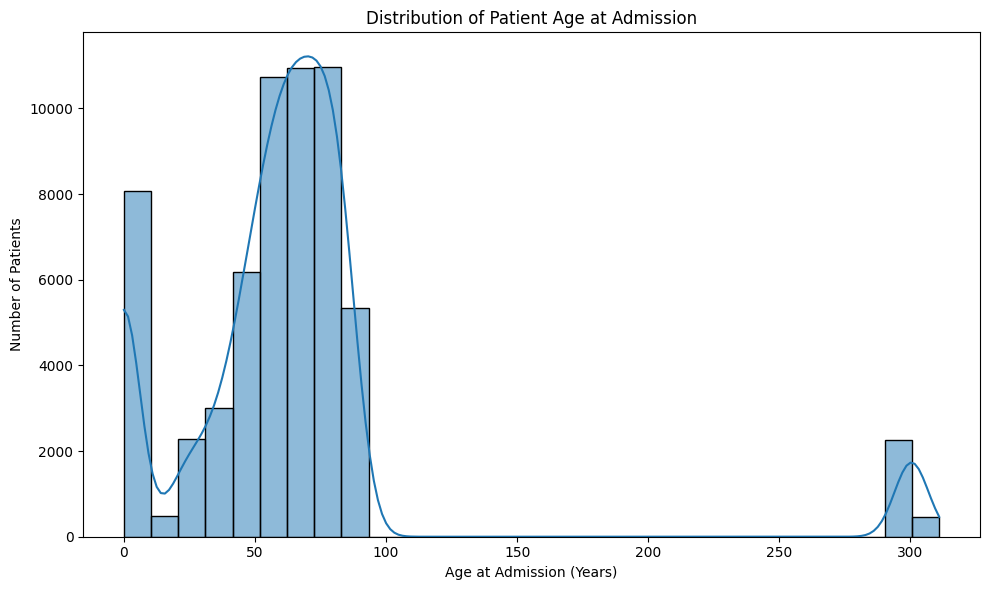


Age at Admission Statistics:
count    60748.000000
mean        64.939998
std         57.138132
min          0.000000
25%         44.000000
50%         62.000000
75%         76.000000
max        311.000000
Name: AGE_AT_ADMISSION, dtype: float64
Query Execution Time: 2.38 seconds


In [19]:
start_time = time.time()

# 1. Filter Dask DataFrame for non-null AGE_AT_ADMISSION
age_ddf = ddf["AGE_AT_ADMISSION"]

# 2. Compute to Pandas
age_series = age_ddf.compute()
age_df = age_series.to_frame(name="AGE_AT_ADMISSION")  # <- Convert to DataFrame

# 3. Plot histogram + KDE
if not age_df.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=age_df, x='AGE_AT_ADMISSION', kde=True, bins=30)
    plt.xlabel("Age at Admission (Years)")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patient Age at Admission")
    plt.tight_layout()
    plt.show()
else:
    print("No non-null AGE_AT_ADMISSION values to plot.")

# 4. Print summary statistics
print("\nAge at Admission Statistics:")
print(age_df["AGE_AT_ADMISSION"].describe())

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")


### **Eliminating rows with Age bigger then 120 years**
Given the histogram results, we decided to eliminate the rows with outliers that most definitely represent input errors, given that there are no people near 300 years old.

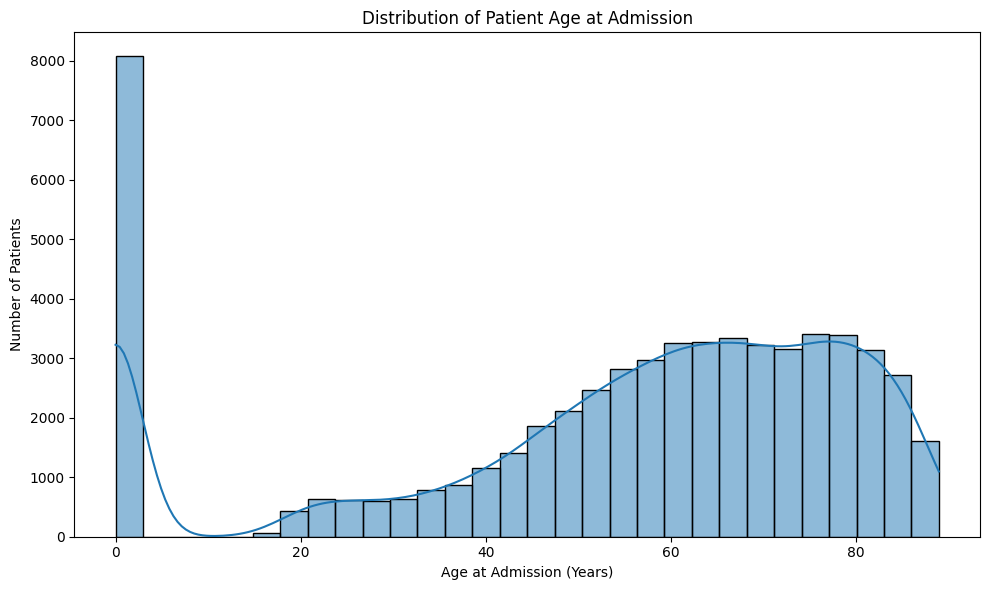


Age at Admission Statistics:
count    58039.000000
mean        53.943693
std         26.560400
min          0.000000
25%         43.000000
50%         61.000000
75%         74.000000
max         89.000000
Name: AGE_AT_ADMISSION, dtype: float64
Query Execution Time: 0.78 seconds


In [21]:
start_time = time.time()

age_df_filtered = age_df[age_df["AGE_AT_ADMISSION"] <= 120]

# 3. Plot histogram + KDE
if not age_df_filtered.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=age_df_filtered, x='AGE_AT_ADMISSION', kde=True, bins=30)
    plt.xlabel("Age at Admission (Years)")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patient Age at Admission")
    plt.tight_layout()
    plt.show()
else:
    print("No non-null AGE_AT_ADMISSION values to plot.")

# 4. Print summary statistics
print("\nAge at Admission Statistics:")
print(age_df_filtered["AGE_AT_ADMISSION"].describe())

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

After eliminating these input error mistakes, we ended up with a table containing 58039 rows (~95.5% of the previous table).

### **Age & Length of ICU Stay**

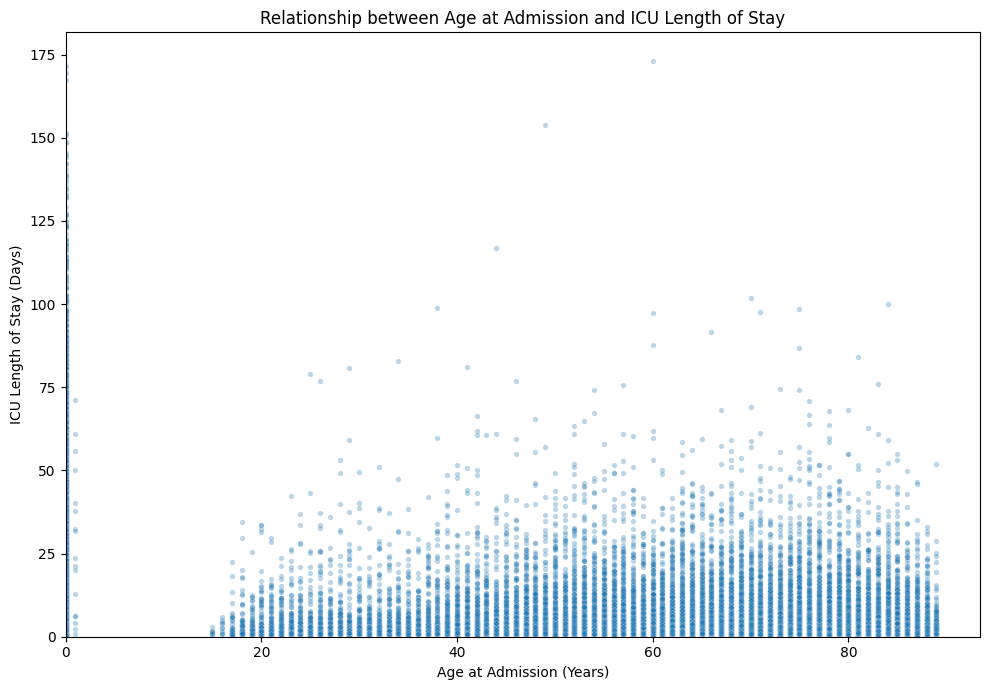


Correlation between Age at Admission and ICU LOS: -0.161
Query Execution Time: 6.84 seconds


In [28]:
start_time = time.time()

# 1. Filter AGE_AT_ADMISSION to remove outliers
filtered_ddf = ddf[ddf["AGE_AT_ADMISSION"] <= 100]

# 2. Select relevant columns and bring to memory
age_los_df = filtered_ddf[["AGE_AT_ADMISSION", "ICU_LOS"]].compute()

# 3. Plot and correlation
if not age_los_df.empty:
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x="AGE_AT_ADMISSION", y="ICU_LOS", data=age_los_df, alpha=0.3, s=15)
    plt.xlabel("Age at Admission (Years)")
    plt.ylabel("ICU Length of Stay (Days)")
    plt.title("Relationship between Age at Admission and ICU Length of Stay")
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.tight_layout()
    plt.show()

    # Correlation
    correlation = age_los_df["AGE_AT_ADMISSION"].corr(age_los_df["ICU_LOS"])
    print(f"\nCorrelation between Age at Admission and ICU LOS: {correlation:.3f}")
else:
    print("No data to plot.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
By analysing the histogram of `Age`, we can see that the most common age intervals in the dataset are `0` and `50-80`. The dataset proposely ommits data from minor patients with the excpetion of newborns.

Regarding the connection between `Age` and `Length of ICU Stay`, we can conclude that:
1. The vast majority of ICU stays are relatively short (concentrated roughly below 25 days) across all adult age groups.
2. While short stays are common for all ages, the spread of the values of `Length of ICU Stay` appears to widen slightly for older patients, which means that very long stays seem slightly more prevalent among older age groups.

### **Insurance Analysis**

/usr/local/lib/python3.11/dist-packages/dask/dataframe/dask_expr/_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
<ipython-input-34-7ff799173bd5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='INSURANCE', data=insurance_counts, palette='magma', orient='h')


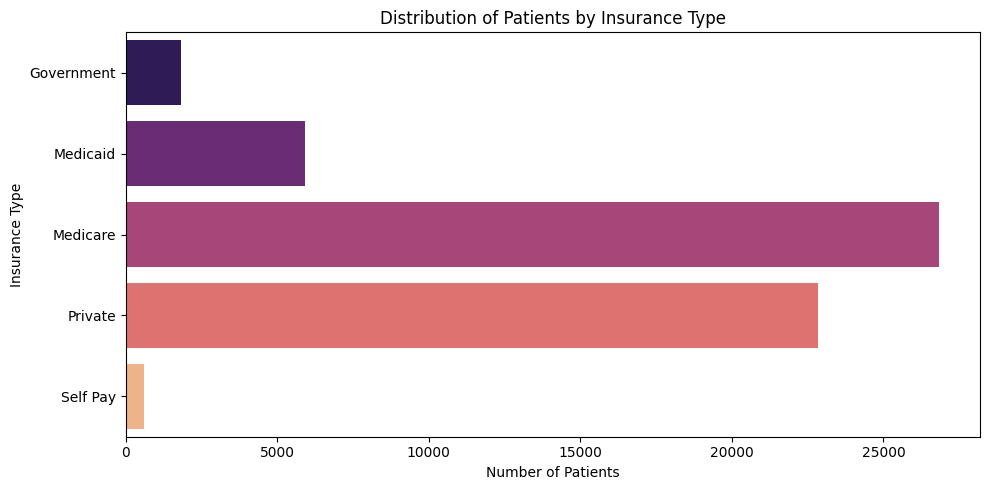

Query Execution Time: 2.77 seconds


In [34]:
start_time = time.time()

# 1. Group by insurance and count occurrences
insurance_counts = (
    filtered_ddf.groupby("INSURANCE")
       .size()
       .compute()
       .sort_values(ascending=False)
       .reset_index(name="count")
       .rename(columns={0: "INSURANCE"})
)

# 2. Plot horizontal bar chart
if not insurance_counts.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x='count', y='INSURANCE', data=insurance_counts, palette='magma', orient='h')
    plt.xlabel("Number of Patients")
    plt.ylabel("Insurance Type")
    plt.title("Distribution of Patients by Insurance Type")
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Insurance & Length of ICU Stay**

<ipython-input-36-e7db03b38274>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='INSURANCE', y='ICU_LOS', data=insurance_los_df, palette='magma', showfliers=False)


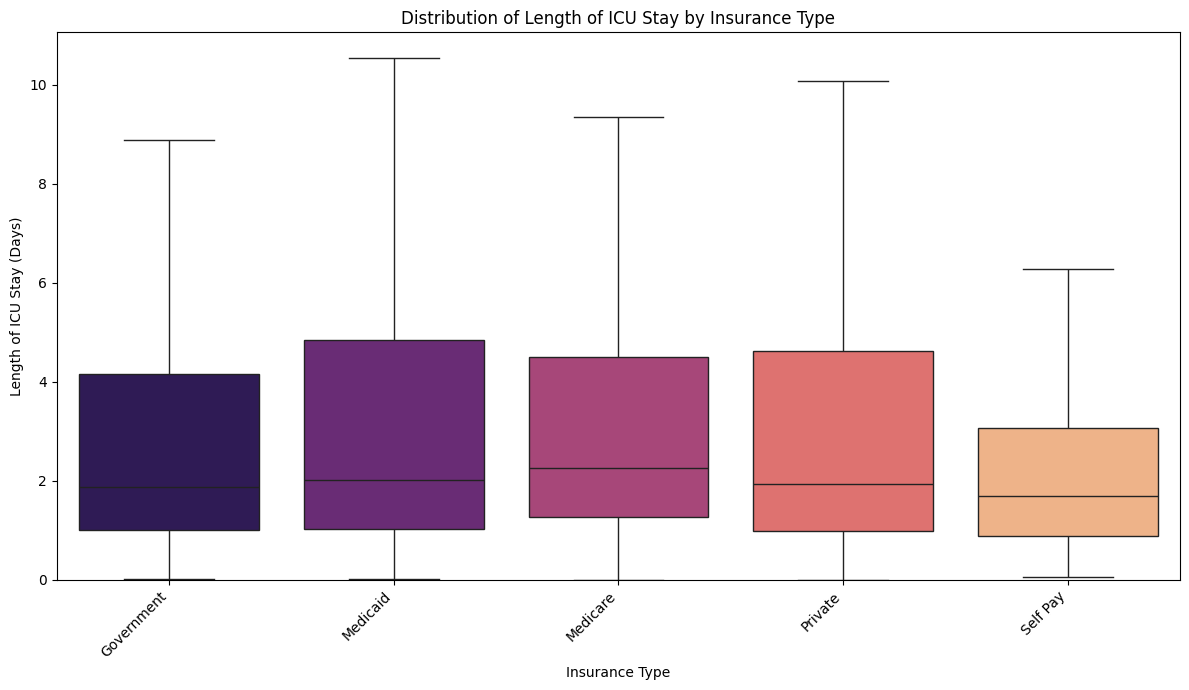


Summary Statistics for ICU LOS by Insurance Type:
              count      mean        std     min       25%      50%       75%  \
INSURANCE                                                                       
Government   1822.0  4.895602   9.793321  0.0057  0.998850  1.87805  4.167150   
Medicaid     5919.0  5.900825  12.800130  0.0036  1.025900  2.02050  4.835200   
Medicare    26843.0  4.306665   6.252719  0.0001  1.260800  2.26430  4.501300   
Private     22845.0  5.611555  12.140707  0.0002  0.982100  1.92950  4.625200   
Self Pay      610.0  3.062356   4.486948  0.0614  0.888425  1.68900  3.057675   

                 max  
INSURANCE             
Government  101.8397  
Medicaid    169.4202  
Medicare    173.0725  
Private     171.6227  
Self Pay     43.1465  
Query Execution Time: 7.77 seconds


<ipython-input-36-e7db03b38274>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(insurance_los_df.groupby("INSURANCE")["ICU_LOS"].describe())


In [36]:
start_time = time.time()

# 1. Select relevant columns
insurance_los_ddf = filtered_ddf[["INSURANCE", "ICU_LOS"]]

# 2. Bring to memory for plotting/stats
insurance_los_df = insurance_los_ddf.compute()

# 3. Plot and summarize
if not insurance_los_df.empty:
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='INSURANCE', y='ICU_LOS', data=insurance_los_df, palette='magma', showfliers=False)
    plt.xlabel("Insurance Type")
    plt.ylabel("Length of ICU Stay (Days)")
    plt.title("Distribution of Length of ICU Stay by Insurance Type")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nSummary Statistics for ICU LOS by Insurance Type:")
    print(insurance_los_df.groupby("INSURANCE")["ICU_LOS"].describe())
else:
    print("No data returned for insurance vs. LOS analysis.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
By analysing the bar chart of `Insurance`, we can see that the most common insurance systems are `Medicare` followed by `Private`, and that there is a significantly lower number of patients using other systems.

Regarding the connection between `Insurance` and `Length of ICU Stay`, we can conclude that all systems have a similar distribution and mean in the comparison of the two metrics, with the exception of `Self Pay`, whose average value for `Length of ICU Stay` is significantly lower.

## **Medical Data**
We will continue the dataset analysis with an in-depth analysis of the features regarding patients medical records while they were hositalized, which include:

- `Type of Admission`
- `Diagnostic Code`
- `First Care Unit`
- `Length of ICU Stay (Target)`

### **Type of Admission Analysis**

/usr/local/lib/python3.11/dist-packages/dask/dataframe/dask_expr/_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
<ipython-input-33-6ba51112c5e1>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='ADMISSION_TYPE', y='count', data=adm_type_counts, palette='cubehelix')


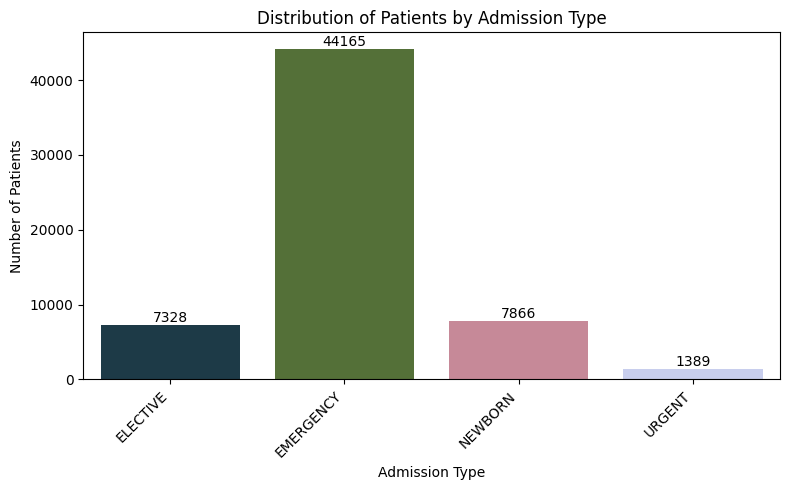

Query Execution Time: 2.66 seconds


In [33]:
start_time = time.time()

# 1. Group by ADMISSION_TYPE and count
adm_type_counts = (
    filtered_ddf.groupby("ADMISSION_TYPE")
       .size()
       .compute()
       .sort_values(ascending=False)
       .reset_index(name="count")
)

# 2. Plot bar chart
if not adm_type_counts.empty:
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='ADMISSION_TYPE', y='count', data=adm_type_counts, palette='cubehelix')
    plt.xlabel("Admission Type")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patients by Admission Type")
    plt.xticks(rotation=45, ha='right')

    # Add value labels to bars
    for container in ax.containers:
        ax.bar_label(container)

    plt.tight_layout()
    plt.show()
else:
    print("No data returned for admission type distribution.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Type of Admission & Length of ICU Stay**

<ipython-input-37-1121dcee2c5f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='ADMISSION_TYPE', y='ICU_LOS', data=adm_type_los_df, palette='cubehelix', showfliers=False)


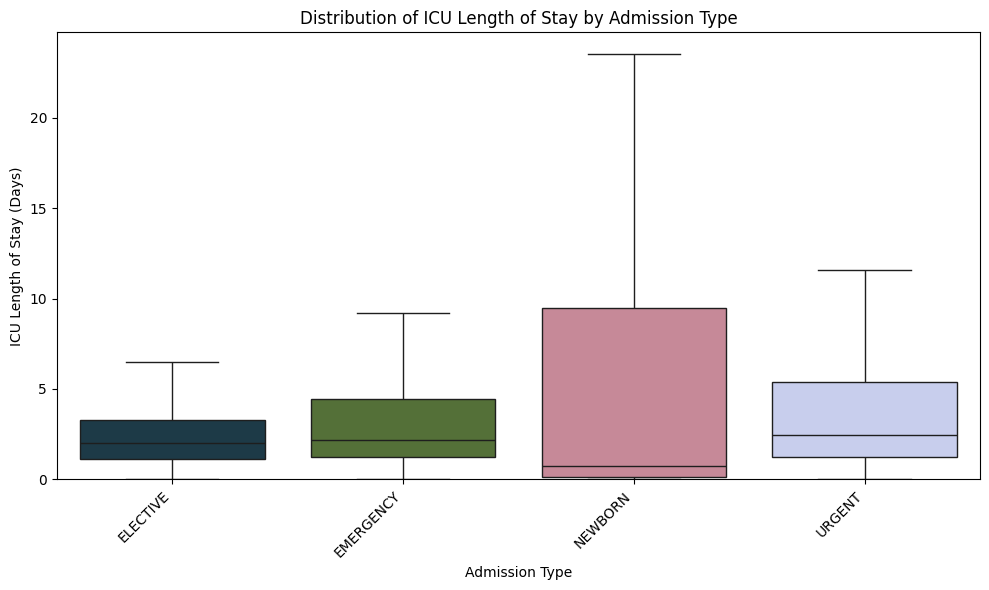


Summary Statistics for ICU LOS by Admission Type:
                  count      mean        std     min       25%     50%  \
ADMISSION_TYPE                                                           
ELECTIVE         7226.0  3.503513   6.008552  0.0004  1.140675  1.9895   
EMERGENCY       41601.0  4.309662   6.436865  0.0001  1.229700  2.1897   
NEWBORN          7866.0  9.878190  20.483139  0.0008  0.137675  0.7253   
URGENT           1346.0  5.356694   8.359788  0.0025  1.241075  2.4351   

                     75%       max  
ADMISSION_TYPE                      
ELECTIVE        3.283750  173.0725  
EMERGENCY       4.420000  169.4202  
NEWBORN         9.500975  171.6227  
URGENT          5.380250   97.4897  
Query Execution Time: 8.09 seconds


<ipython-input-37-1121dcee2c5f>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(adm_type_los_df.groupby("ADMISSION_TYPE")["ICU_LOS"].describe())


In [37]:
start_time = time.time()

# 1. Select relevant columns from the cleaned DataFrame
adm_type_los_ddf = filtered_ddf[["ADMISSION_TYPE", "ICU_LOS"]]

# 2. Compute to Pandas
adm_type_los_df = adm_type_los_ddf.compute()

# 3. Plot and describe
if not adm_type_los_df.empty:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='ADMISSION_TYPE', y='ICU_LOS', data=adm_type_los_df, palette='cubehelix', showfliers=False)
    plt.xlabel("Admission Type")
    plt.ylabel("ICU Length of Stay (Days)")
    plt.title("Distribution of ICU Length of Stay by Admission Type")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nSummary Statistics for ICU LOS by Admission Type:")
    print(adm_type_los_df.groupby("ADMISSION_TYPE")["ICU_LOS"].describe())
else:
    print("No data returned for admission type vs. LOS analysis.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
The distributions of patients by `Type of Admission` is uneven, with most admissions being classified as `EMERGENCY`. The least recurrent type of admissions is `Urgent`.

There is an evident connection between `Type of Admission` and `Length of ICU Stay`, with `NEWBORN` having the highest mean values (close to 10 days) while the other types of admission have mean values between 3 to 5 days.

### **Diagnosis Analysis**

<ipython-input-51-bd3e9e7b3720>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


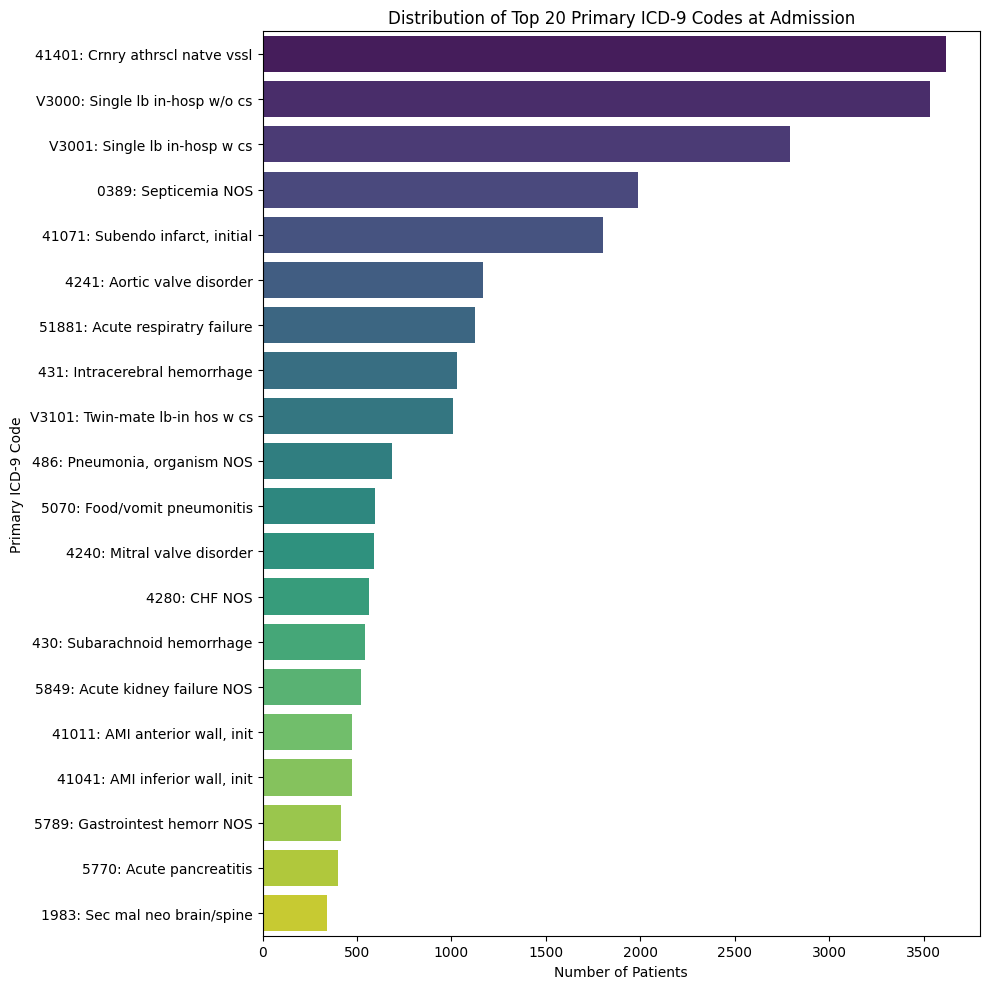


Top ICD-9 Code Distribution:
   PRIMARY_ICD9_CODE  count        PRIMARY_ICD9_TITLE
0              41401   3617  Crnry athrscl natve vssl
1              V3000   3534  Single lb in-hosp w/o cs
2              V3001   2792    Single lb in-hosp w cs
3               0389   1988            Septicemia NOS
4              41071   1803  Subendo infarct, initial
5               4241   1168     Aortic valve disorder
6              51881   1124  Acute respiratry failure
7                431   1031  Intracerebral hemorrhage
8              V3101   1008  Twin-mate lb-in hos w cs
9                486    684   Pneumonia, organism NOS
10              5070    596    Food/vomit pneumonitis
11              4240    592     Mitral valve disorder
12              4280    562                   CHF NOS
13               430    542   Subarachnoid hemorrhage
14              5849    523  Acute kidney failure NOS
15             41011    473   AMI anterior wall, init
16             41041    471   AMI inferior wall, ini

In [51]:
start_time = time.time()

# Ensure PRIMARY_ICD9_CODE is string
filtered_ddf = filtered_ddf.assign(PRIMARY_ICD9_CODE=filtered_ddf["PRIMARY_ICD9_CODE"].astype(str))

# 1. Count top 20 ICD-9 codes (and fix column names properly)
icd_counts = (
    filtered_ddf["PRIMARY_ICD9_CODE"]
    .value_counts()
    .compute()
    .nlargest(20)
    .reset_index()
    .rename(columns={"index": "PRIMARY_ICD9_CODE", 0: "count"})
)

# 2. Get titles
icd_titles = (
    filtered_ddf[["PRIMARY_ICD9_CODE", "PRIMARY_ICD9_TITLE"]]
    .drop_duplicates(subset=["PRIMARY_ICD9_CODE"])
    .compute()
    .dropna(subset=["PRIMARY_ICD9_TITLE"])
)

# 3. Merge counts with titles
icd9_distribution_df = icd_counts.merge(icd_titles, on="PRIMARY_ICD9_CODE", how="left")

# 4. Plot
if not icd9_distribution_df.empty:
    plt.figure(figsize=(10, 10))
    icd9_distribution_df["PRIMARY_ICD9_TITLE"] = icd9_distribution_df["PRIMARY_ICD9_TITLE"].astype(str)
    icd9_distribution_df["CODE_TITLE"] = (
        icd9_distribution_df["PRIMARY_ICD9_CODE"] + ": " +
        icd9_distribution_df["PRIMARY_ICD9_TITLE"].replace("nan", "N/A")
    )

    sns.barplot(
        x="count",
        y="CODE_TITLE",
        data=icd9_distribution_df,
        palette="viridis",
        orient="h"
    )

    plt.xlabel("Number of Patients")
    plt.ylabel("Primary ICD-9 Code")
    plt.title("Distribution of Top 20 Primary ICD-9 Codes at Admission")
    plt.tight_layout()
    plt.show()

    print("\nTop ICD-9 Code Distribution:")
    print(icd9_distribution_df[["PRIMARY_ICD9_CODE", "count", "PRIMARY_ICD9_TITLE"]])
else:
    print("No data returned for primary ICD-9 code distribution.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Diagnosis & Length of ICU Stay**

<ipython-input-52-3bf58f3a6526>:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


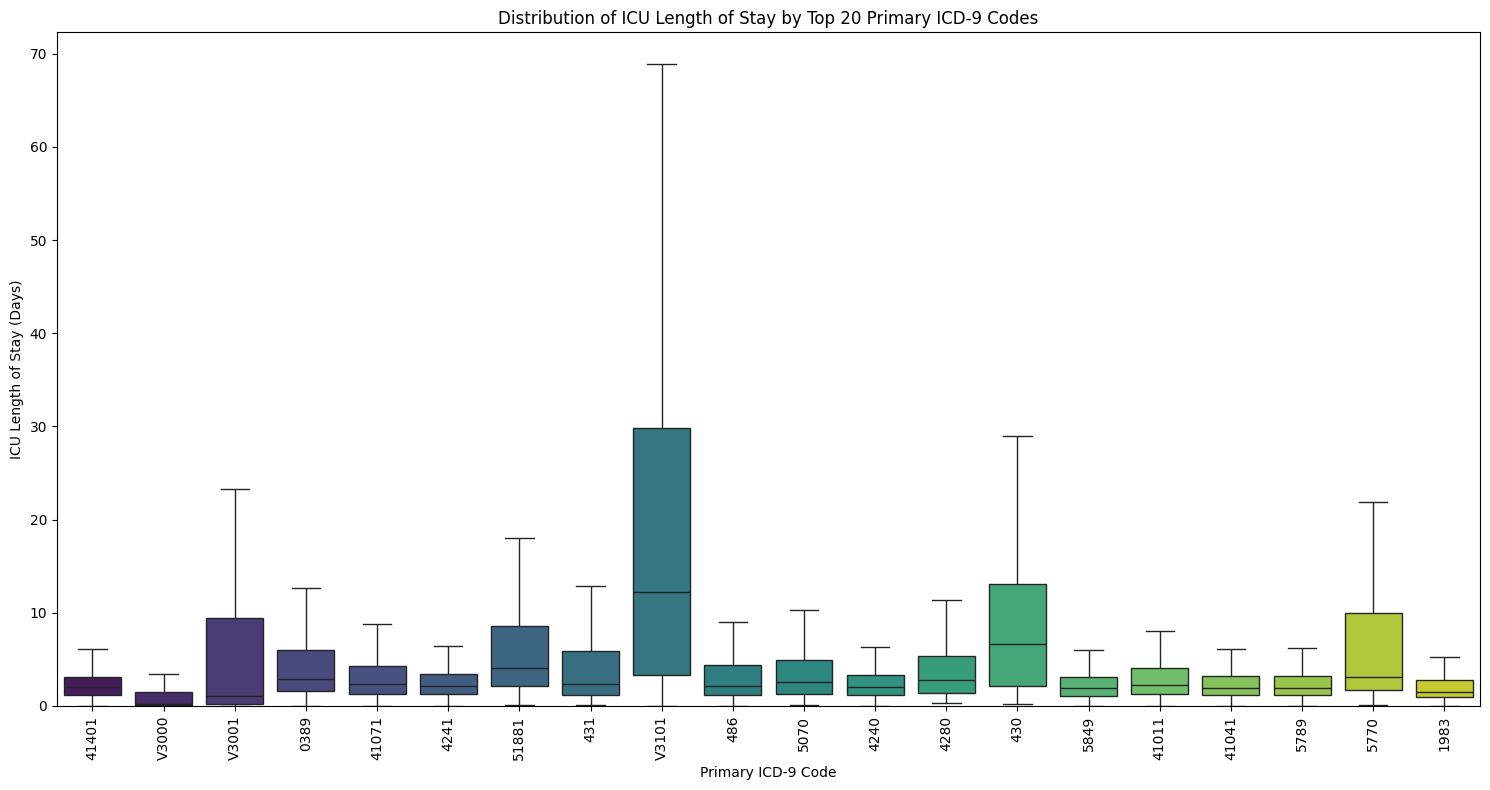


Summary Statistics for ICU LOS by Top 20 Primary ICD-9 Codes:
                    count       mean        std     min       25%       50%  \
PRIMARY_ICD9_CODE                                                             
0389               1988.0   5.329782   7.084884  0.0079  1.614200   2.87470   
1983                343.0   2.509505   3.203271  0.0079  1.005550   1.51880   
41011               473.0   3.895759   5.718157  0.0435  1.314000   2.20950   
41041               471.0   3.449264   4.951962  0.0033  1.230300   1.94030   
41071              1803.0   4.026161   5.369919  0.0016  1.288900   2.35840   
41401              3617.0   2.876750   3.885769  0.0048  1.154600   1.99070   
4240                592.0   3.466497   5.780785  0.0077  1.159450   2.02135   
4241               1168.0   3.624112   5.788327  0.0014  1.233175   2.14675   
4280                562.0   4.949970   6.628354  0.3021  1.387300   2.73745   
430                 542.0   9.060081   8.904613  0.1733  2.170775   

In [52]:
start_time = time.time()

# Ensure PRIMARY_ICD9_CODE is as string
filtered_ddf = filtered_ddf.assign(PRIMARY_ICD9_CODE=filtered_ddf["PRIMARY_ICD9_CODE"].astype(str))

# 1. Get top 20 most frequent ICD-9 codes (as strings)
top_codes_list = (
    filtered_ddf["PRIMARY_ICD9_CODE"]
    .value_counts()
    .compute()
    .nlargest(20)
    .index
    .tolist()
)

# 2. Filter and select necessary columns
if top_codes_list:
    icd9_los_ddf = filtered_ddf[
        filtered_ddf["PRIMARY_ICD9_CODE"].isin(top_codes_list)
    ][["PRIMARY_ICD9_CODE", "ICU_LOS"]]

    # 3. Compute to pandas
    icd9_los_df = icd9_los_ddf.compute()

    # 4. Plot
    if not icd9_los_df.empty:
        plt.figure(figsize=(15, 8))
        sns.boxplot(
            x="PRIMARY_ICD9_CODE",
            y="ICU_LOS",
            data=icd9_los_df,
            palette="viridis",
            order=top_codes_list,
            showfliers=False
        )
        plt.xlabel("Primary ICD-9 Code")
        plt.ylabel("ICU Length of Stay (Days)")
        plt.title("Distribution of ICU Length of Stay by Top 20 Primary ICD-9 Codes")
        plt.xticks(rotation=90)
        plt.ylim(bottom=0)
        plt.tight_layout()
        plt.show()

        print("\nSummary Statistics for ICU LOS by Top 20 Primary ICD-9 Codes:")
        print(icd9_los_df.groupby("PRIMARY_ICD9_CODE")["ICU_LOS"].describe())

    else:
        print("No data returned for top ICD-9 codes vs. LOS analysis.")
else:
    print("Cannot proceed with LOS analysis as no top ICD-9 codes were identified.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
There is a very unsymmetric distribution of Diagnosis. In the top-20 most common diagnosis, with the most common being `41401 (Coronary atherosclerosis of native vessel)`.
The correlation between some `Diagnosis` and `ICU Length of Stay` is evident, with `V3101 (Twin mate, liveborn, delivered in hospital, with cesarean section)` having a mean value very high compared to other types of Diagnosis. There are also diagnosis who have an average of `ICU Length of Stay` very low in comparison, like `V3000 (Single liveborn, delivered in hospital, without cesarean section)`.



### **First Care Unit Analysis**

/usr/local/lib/python3.11/dist-packages/dask/dataframe/dask_expr/_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(
<ipython-input-53-9eb78ae8727a>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="FIRST_CAREUNIT", y="count", data=careunit_counts, palette="Spectral")


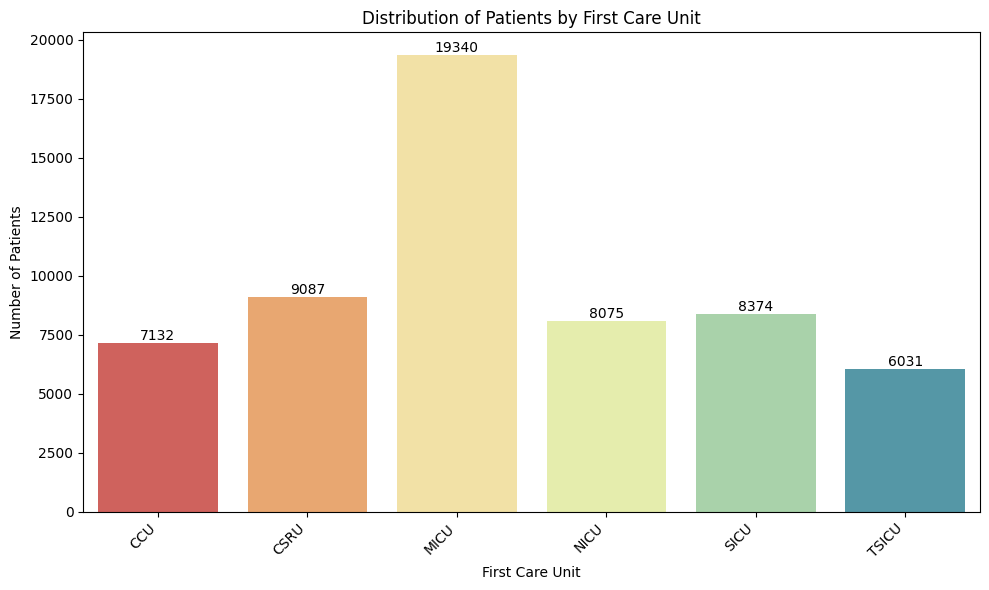

Query Execution Time: 3.80 seconds


In [53]:
start_time = time.time()

# 1. Group by FIRST_CAREUNIT and count
careunit_counts = (
    filtered_ddf.groupby("FIRST_CAREUNIT")
    .size()
    .compute()
    .sort_values(ascending=False)
    .reset_index(name="count")
)

# 2. Plot
if not careunit_counts.empty:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="FIRST_CAREUNIT", y="count", data=careunit_counts, palette="Spectral")
    plt.xlabel("First Care Unit")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of Patients by First Care Unit")
    plt.xticks(rotation=45, ha="right")

    # Add count labels
    for container in ax.containers:
        ax.bar_label(container)

    plt.tight_layout()
    plt.show()
else:
    print("No data returned for first care unit distribution.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **First Care of Unit & Length of ICU Stay**

<ipython-input-54-e2d327078eaf>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


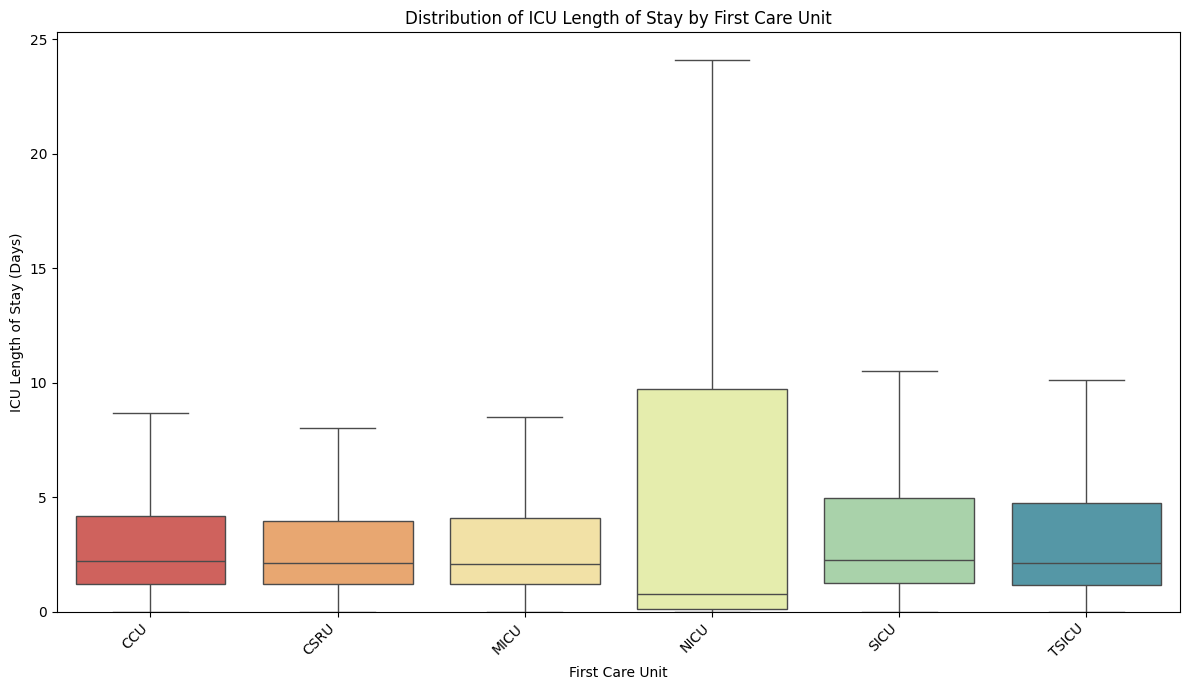


Summary Statistics for ICU LOS by First Care Unit:
                  count       mean        std     min       25%      50%  \
FIRST_CAREUNIT                                                             
CCU              7132.0   3.953257   5.619626  0.0012  1.213125  2.19915   
CSRU             9087.0   3.888229   6.097731  0.0001  1.213850  2.14770   
MICU            19340.0   4.042175   5.890149  0.0004  1.189600  2.09700   
NICU             8075.0  10.004395  20.644582  0.0008  0.140500  0.78470   
SICU             8374.0   4.749462   6.997957  0.0003  1.258775  2.26470   
TSICU            6031.0   4.519062   6.760158  0.0016  1.174100  2.12800   

                     75%       max  
FIRST_CAREUNIT                      
CCU             4.200700  100.1225  
CSRU            3.943200  153.9280  
MICU            4.109775  116.8327  
NICU            9.723350  171.6227  
SICU            4.964775  101.7390  
TSICU           4.755900  173.0725  
Query Execution Time: 8.19 seconds


<ipython-input-54-e2d327078eaf>:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(careunit_los_df.groupby("FIRST_CAREUNIT")["ICU_LOS"].describe())


In [54]:
start_time = time.time()

# 1. Select relevant columns from the cleaned DataFrame
careunit_los_ddf = filtered_ddf[["FIRST_CAREUNIT", "ICU_LOS"]]

# 2. Compute to Pandas
careunit_los_df = careunit_los_ddf.compute()

# 3. Plot and describe
if not careunit_los_df.empty:
    plt.figure(figsize=(12, 7))
    sns.boxplot(
        x="FIRST_CAREUNIT",
        y="ICU_LOS",
        data=careunit_los_df,
        palette="Spectral",
        showfliers=False
    )
    plt.xlabel("First Care Unit")
    plt.ylabel("ICU Length of Stay (Days)")
    plt.title("Distribution of ICU Length of Stay by First Care Unit")
    plt.xticks(rotation=45, ha="right")
    plt.ylim(bottom=0)
    plt.tight_layout()
    plt.show()

    # Summary statistics
    print("\nSummary Statistics for ICU LOS by First Care Unit:")
    print(careunit_los_df.groupby("FIRST_CAREUNIT")["ICU_LOS"].describe())
else:
    print("No data returned for first care unit vs. LOS analysis.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
There is a relative uniform distribution in the number of patients by `First Care Unit` with the exception being `MICU (Medical Intensive Care Unit)`, that has a count of patients that is more than double of each other type of `First Care Unit`.

The correlation between `Type of Care Unit`and `ICU Length of Stay`is also relatively uniform with an exception, `NICU (Neonatal Intensive Care Unit)`.


### **Length of ICU Stay Analysis**

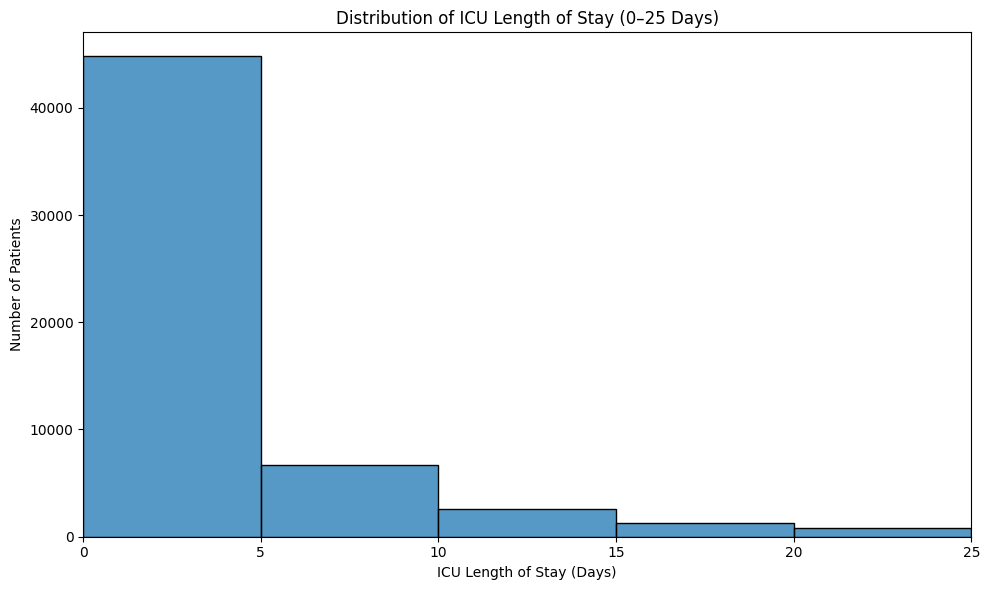


ICU Length of Stay Statistics:
count    58039.000000
mean         4.988276
std          9.824303
min          0.000100
25%          1.103350
50%          2.091800
75%          4.550800
max        173.072500
Name: ICU_LOS, dtype: float64
Query Execution Time: 6.30 seconds


In [55]:
start_time = time.time()

# 1. Select ICU_LOS column from the filtered dataframe
icu_los_series = filtered_ddf["ICU_LOS"]

# 2. Compute to Pandas for plotting
icu_los_df = icu_los_series.compute().to_frame(name="ICU_LOS")

# 3. Filter for LOS within 0–25 days
plot_data = icu_los_df[(icu_los_df["ICU_LOS"] >= 0) & (icu_los_df["ICU_LOS"] <= 25)]

# 4. Plot
if not plot_data.empty:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=plot_data, x="ICU_LOS", kde=False, bins=5)
    plt.xlabel("ICU Length of Stay (Days)")
    plt.ylabel("Number of Patients")
    plt.title("Distribution of ICU Length of Stay (0–25 Days)")
    plt.xlim(left=0, right=25)
    plt.tight_layout()
    plt.show()

    # Descriptive stats
    print("\nICU Length of Stay Statistics:")
    print(icu_los_df["ICU_LOS"].describe())
else:
    print("No data returned for ICU LOS distribution (0–25 days).")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
By analysing the distribution of `ICU Length of Stay` we can see clearly that most of patients only stay for `5 days or less`, with a decreasing trend of the number of patients as the number of days increases.

## **Correlations**
To finish this analysis we will attemp to find connectios between the following set of features:

- `Type of Admission & Hour of Admission`
- `Type of Admission and Death`
- `Diagnosis & First Care Unit`
- `First Care Unit & Death`

### **Type of Admission & Hour of Admission**

/usr/local/lib/python3.11/dist-packages/dask/dataframe/dask_expr/_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


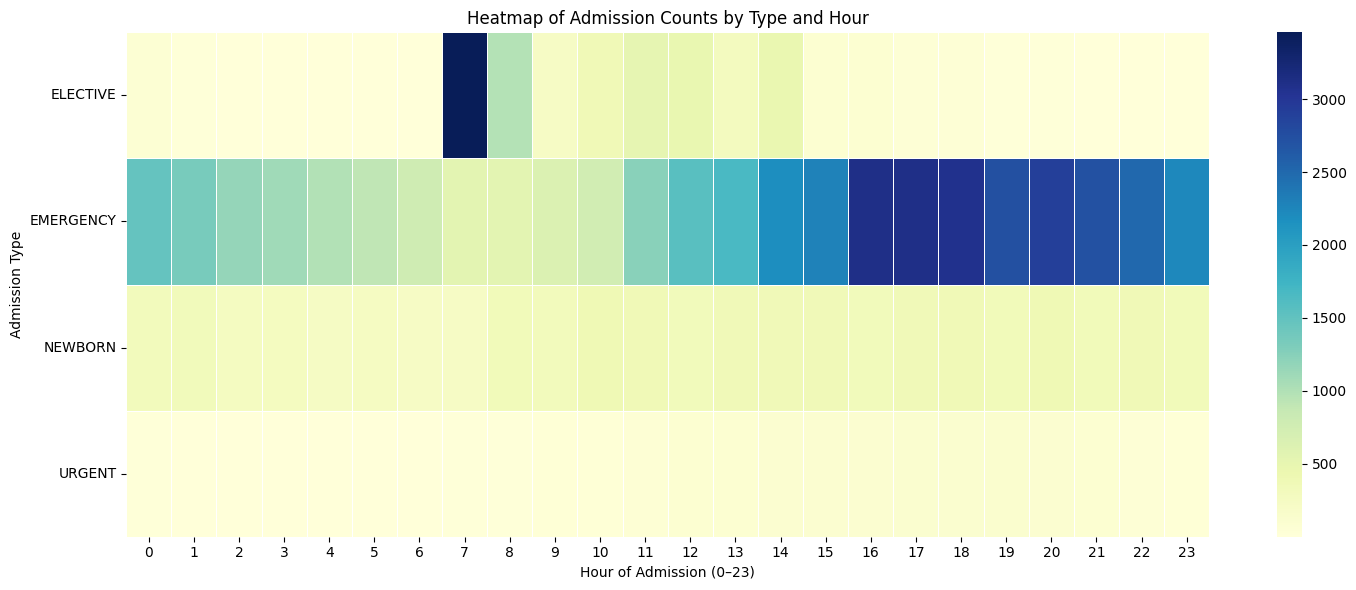


Pivoted Data for Heatmap:
ADMISSION_HOUR      0       1       2       3      4      5      6       7   \
ADMISSION_TYPE                                                                
ELECTIVE          70.0    20.0    12.0     9.0    2.0    4.0    6.0  3457.0   
EMERGENCY       1474.0  1348.0  1169.0  1095.0  989.0  917.0  778.0   552.0   
NEWBORN          324.0   330.0   265.0   282.0  236.0  245.0  226.0   229.0   
URGENT            23.0    14.0    12.0    10.0    4.0    8.0   13.0    23.0   

ADMISSION_HOUR     8      9   ...      14      15      16      17      18  \
ADMISSION_TYPE                ...                                           
ELECTIVE        986.0  222.0  ...   461.0    84.0    87.0    51.0    42.0   
EMERGENCY       554.0  643.0  ...  2184.0  2292.0  3111.0  3111.0  3077.0   
NEWBORN         347.0  320.0  ...   356.0   356.0   337.0   353.0   378.0   
URGENT           19.0   30.0  ...    98.0   101.0   104.0   111.0   111.0   

ADMISSION_HOUR      19      20     

In [60]:
start_time = time.time()

# 1. Group by ADMISSION_TYPE and ADMISSION_HOUR and count occurrences
adm_type_hour_df = (
    filtered_ddf.groupby(["ADMISSION_TYPE", "ADMISSION_HOUR"])
    .size()
    .compute()
    .reset_index(name="count")
)

# 2. Ensure numeric types
adm_type_hour_df["count"] = pd.to_numeric(adm_type_hour_df["count"], errors="coerce")
adm_type_hour_df["ADMISSION_HOUR"] = pd.to_numeric(adm_type_hour_df["ADMISSION_HOUR"], errors="coerce")
adm_type_hour_df.dropna(subset=["count", "ADMISSION_HOUR"], inplace=True)

# 3. Plot heatmap
if not adm_type_hour_df.empty:
    try:
        heatmap_data = (
            adm_type_hour_df
            .pivot(index="ADMISSION_TYPE", columns="ADMISSION_HOUR", values="count")
            .fillna(0)
            .astype(float)
        )

        plt.figure(figsize=(15, 6))
        sns.heatmap(heatmap_data, annot=False, fmt=".0f", linewidths=.5, cmap="YlGnBu")
        plt.xlabel("Hour of Admission (0–23)")
        plt.ylabel("Admission Type")
        plt.title("Heatmap of Admission Counts by Type and Hour")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # Print the table
        print("\nPivoted Data for Heatmap:")
        print(heatmap_data)
        print("\nPivoted Data Types:")
        print(heatmap_data.dtypes)

    except Exception as e:
        print(f"An error occurred during plotting: {e}")
        print("\nOriginal DataFrame dtypes before pivot:")
        print(adm_type_hour_df.dtypes)
        if "heatmap_data" in locals():
            print("\nPivoted DataFrame dtypes before plotting:")
            print(heatmap_data.dtypes)

else:
    print("No data returned from the grouped admission type/hour analysis.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
By visualizing the heatmap, we can see that the `EMERGENCY` `Type of Admission` is very correlated with `Hour of Admission`, being much more common in the evening/night `16PM – 23PM`. The `Type of Admission` `ELECTIVE` is also correlated with `Hour of Admission`, being very common at `7AM`.

### **Type of Admission & Death**

/usr/local/lib/python3.11/dist-packages/dask/dataframe/dask_expr/_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


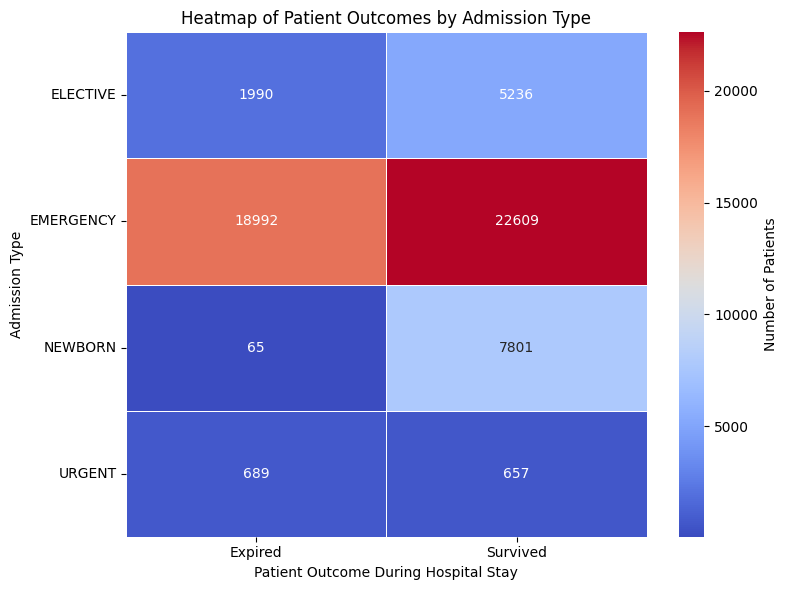


Pivoted Data for Heatmap:
Outcome         Expired  Survived
ADMISSION_TYPE                   
ELECTIVE         1990.0    5236.0
EMERGENCY       18992.0   22609.0
NEWBORN            65.0    7801.0
URGENT            689.0     657.0
Query Execution Time: 3.20 seconds


In [57]:
start_time = time.time()

# 1. Group by ADMISSION_TYPE and EXPIRE_FLAG
adm_type_expire_df = (
    filtered_ddf.groupby(["ADMISSION_TYPE", "EXPIRE_FLAG"])
    .size()
    .compute()
    .reset_index(name="count")
)

# 2. Map EXPIRE_FLAG to readable outcome labels
adm_type_expire_df["Outcome"] = adm_type_expire_df["EXPIRE_FLAG"].map({0: "Survived", 1: "Expired"})

# 3. Pivot for heatmap
if not adm_type_expire_df.empty:
    heatmap_data = (
        adm_type_expire_df
        .pivot(index="ADMISSION_TYPE", columns="Outcome", values="count")
        .fillna(0)
        .astype(float)
    )

    # 4. Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".0f",
        linewidths=.5,
        cmap="coolwarm",
        cbar_kws={"label": "Number of Patients"}
    )
    plt.xlabel("Patient Outcome During Hospital Stay")
    plt.ylabel("Admission Type")
    plt.title("Heatmap of Patient Outcomes by Admission Type")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 5. Print pivoted table
    print("\nPivoted Data for Heatmap:")
    print(heatmap_data)
else:
    print("No data returned for outcome heatmap analysis.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
The clearest conclusion from this HeatMap is that patients who have `EMERGENCY` as their `Type of Admission` tend to `EXPIRE` much more frequently.

### **First Care Unit & Diagnosis**

/usr/local/lib/python3.11/dist-packages/dask/dataframe/dask_expr/_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


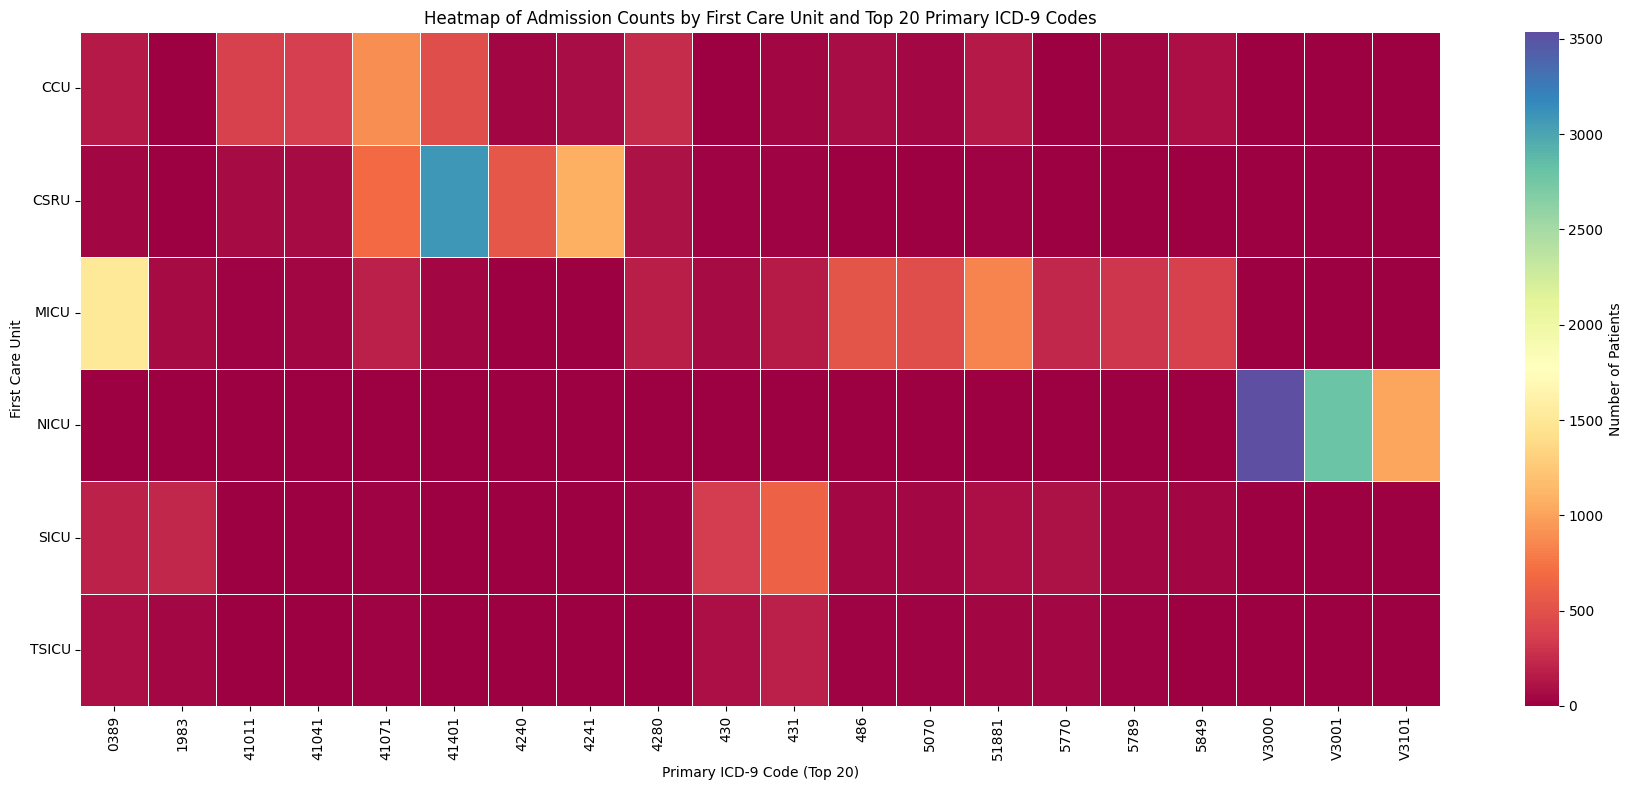


Pivoted Data for Heatmap:
PRIMARY_ICD9_CODE    0389   1983  41011  41041  41071   41401   4240    4241  \
FIRST_CAREUNIT                                                                 
CCU                 150.0    4.0  379.0  371.0  885.0   476.0   37.0    80.0   
CSRU                 31.0    4.0   62.0   67.0  684.0  3092.0  550.0  1075.0   
MICU               1509.0   59.0   27.0   28.0  187.0    38.0    4.0     9.0   
NICU                  0.0    0.0    0.0    0.0    0.0     0.0    0.0     0.0   
SICU                207.0  226.0    1.0    2.0   27.0     6.0    1.0     3.0   
TSICU                91.0   50.0    4.0    3.0   20.0     5.0    0.0     1.0   

PRIMARY_ICD9_CODE   4280    430    431    486   5070  51881   5770   5789  \
FIRST_CAREUNIT                                                              
CCU                251.0   13.0   39.0   74.0   45.0  141.0   13.0   29.0   
CSRU               107.0   18.0   14.0   11.0   12.0   22.0    7.0    9.0   
MICU               173.0

In [58]:
start_time = time.time()

# 1. Force PRIMARY_ICD9_CODE to string
filtered_ddf = filtered_ddf.assign(PRIMARY_ICD9_CODE=filtered_ddf["PRIMARY_ICD9_CODE"].astype(str))

# 2. Get top 20 ICD-9 codes as strings
top_icd9_codes = (
    filtered_ddf["PRIMARY_ICD9_CODE"]
    .value_counts()
    .compute()
    .nlargest(20)
    .index
    .tolist()
)

# 3. Filter rows where ICD-9 is in top list and FIRST_CAREUNIT is not null
careunit_icd9_ddf = filtered_ddf[
    (filtered_ddf["PRIMARY_ICD9_CODE"].isin(top_icd9_codes)) &
    (filtered_ddf["FIRST_CAREUNIT"].notnull())
][["FIRST_CAREUNIT", "PRIMARY_ICD9_CODE"]]

# 4. Group and count
careunit_icd9_df = (
    careunit_icd9_ddf
    .groupby(["FIRST_CAREUNIT", "PRIMARY_ICD9_CODE"])
    .size()
    .compute()
    .reset_index(name="count")
)

# 5. Pivot and plot
if not careunit_icd9_df.empty:
    heatmap_data = (
        careunit_icd9_df
        .pivot(index="FIRST_CAREUNIT", columns="PRIMARY_ICD9_CODE", values="count")
        .fillna(0)
        .astype(float)
    )

    plt.figure(figsize=(18, 8))
    sns.heatmap(
        heatmap_data,
        annot=False,
        fmt=".0f",
        linewidths=.5,
        cmap="Spectral",
        cbar_kws={'label': 'Number of Patients'}
    )
    plt.xlabel("Primary ICD-9 Code (Top 20)")
    plt.ylabel("First Care Unit")
    plt.title("Heatmap of Admission Counts by First Care Unit and Top 20 Primary ICD-9 Codes")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    print("\nPivoted Data for Heatmap:")
    print(heatmap_data)
else:
    print("No data returned for First Care Unit vs Top ICD-9 Code heatmap.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
The strongest connections between `First Care Unit` and `Diagnosis` are `V3000 (Single liveborn, delivered in hospital, without cesarean section)` and `NICU (Neonatal Intensive Care Unit)` and `41401 (Coronary atherosclerosis of native coronary artery)` and  `CSRU (Cardiac Surgery Recovery Unit)`.

### **First Care Unit & Death**

/usr/local/lib/python3.11/dist-packages/dask/dataframe/dask_expr/_groupby.py:1562: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self._meta = self.obj._meta.groupby(


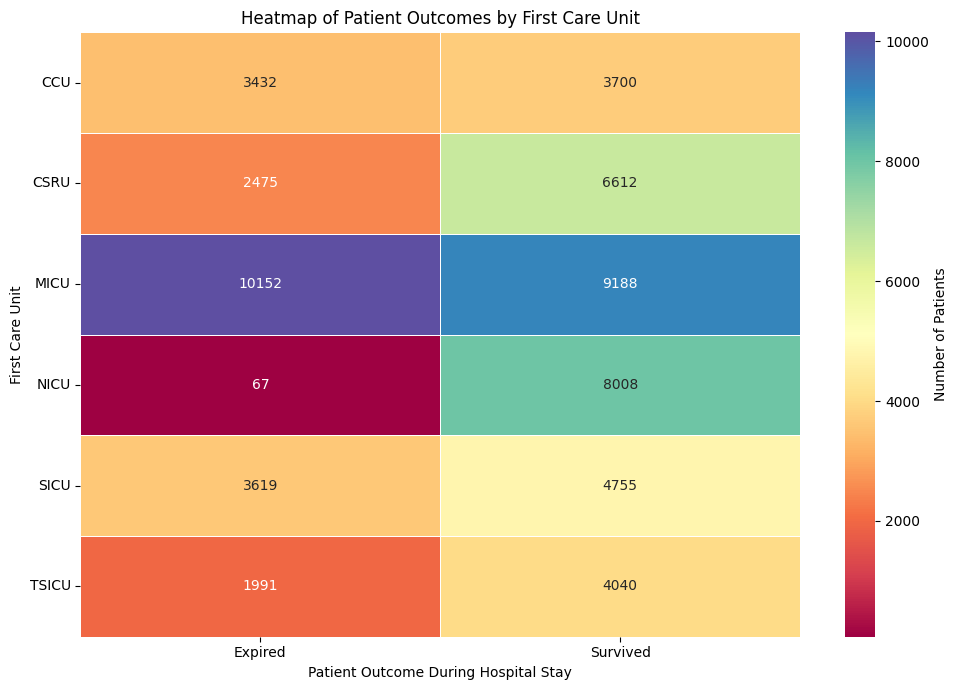


Pivoted Data for Heatmap:
Outcome         Expired  Survived
FIRST_CAREUNIT                   
CCU              3432.0    3700.0
CSRU             2475.0    6612.0
MICU            10152.0    9188.0
NICU               67.0    8008.0
SICU             3619.0    4755.0
TSICU            1991.0    4040.0
Query Execution Time: 4.98 seconds


In [61]:
start_time = time.time()

# 1. Group by FIRST_CAREUNIT and EXPIRE_FLAG
careunit_expire_df = (
    filtered_ddf.groupby(["FIRST_CAREUNIT", "EXPIRE_FLAG"])
    .size()
    .compute()
    .reset_index(name="count")
)

# 2. Map EXPIRE_FLAG to readable labels
careunit_expire_df["Outcome"] = careunit_expire_df["EXPIRE_FLAG"].map({0: "Survived", 1: "Expired"})

# 3. Pivot for heatmap
if not careunit_expire_df.empty:
    heatmap_data = (
        careunit_expire_df
        .pivot(index="FIRST_CAREUNIT", columns="Outcome", values="count")
        .fillna(0)
        .astype(float)
    )

    # 4. Plot
    plt.figure(figsize=(10, 7))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt=".0f",
        linewidths=.5,
        cmap="Spectral",
        cbar_kws={'label': 'Number of Patients'}
    )
    plt.xlabel("Patient Outcome During Hospital Stay")
    plt.ylabel("First Care Unit")
    plt.title("Heatmap of Patient Outcomes by First Care Unit")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 5. Print pivot table
    print("\nPivoted Data for Heatmap:")
    print(heatmap_data)
else:
    print("No data returned for First Care Unit vs Outcome heatmap.")

end_time = time.time()
execution_time = end_time - start_time
print(f"Query Execution Time: {execution_time:.2f} seconds")

### **Conclusion**
In half of the `First Care Units`, the ratio between patients that `expired` and `survived` is fairly equal (and close to 1).
In the other half, which include the units `NICU`, `TSICU` and `CSRU`, the number of patients that `survived` is much higher than the number of patients that `expired`.

# **XGBoost Classifier Predictor Model**
In this section we use a `XGBoost Classifier` model to predict the `ICU Length of Stay`, that we divide in bins of two days ([1-3] days, [3-5] days, ...).
The `window size` we chose was `1 day` (24 hours), given that most data is collected in that window and most records have a value of `ICU Length of Stay` lower than 3 days, which means a bigger window size would exclude most of the data.
We divided this section of the work in 2 parts:
1. Dividing the dataset, Categorizing the Target and Implementing Custom Sample Weights
2. Pre-Processing the features
3. Applying the model
4. Visualizing the results

The discussion of results was done in the final conclusions.



## **Dividing the Dataset, Categorizing the Target and Implementing Custom Sample Weights**
Here we will divide the dataset in Train, Test and Validation.
We will do this by:
1. Eliminating the features that are only collected after the first 24 hours (our `window size`) or are not relevant
2. Removing the records whose value for `ICU Length of Stay` is lower than 24 hours
3. Using the library `scikit-learn` to perform the division
4. Converting the target feature from `continuous values` to `bins`
5. Calculating the custom sample weights to ensure a less biased prediction towards the majority class
6. Normalizing the sample weights

In [64]:
# --- Configuration ---
TARGET_VARIABLE = 'ICU_LOS'
WINDOW_DAYS = 1.0
MAX_ICU_LOS_DAYS = 25.0
BIN_WIDTH = 2.0
TEST_SIZE = 0.10
VALIDATION_SIZE = 0.10
CUSTOM_WEIGHT_ALPHA = 0.8

print("--- Block 1: Dividing Dataset, Target Categorization & CUSTOM Sample Weights ---")
start_time = time.time()

try:
    ddf = filtered_ddf
    original_row_count = ddf.shape[0].compute()
    print(f"Original row count: {original_row_count}")

    ddf = ddf[ddf[TARGET_VARIABLE] >= WINDOW_DAYS]
    rows_after_min_los_filter = ddf.shape[0].compute()
    print(f"Rows remaining after MIN LOS filter (>= {WINDOW_DAYS} days): {rows_after_min_los_filter}")

    ddf = ddf[ddf[TARGET_VARIABLE] <= MAX_ICU_LOS_DAYS]
    rows_after_max_los_filter = ddf.shape[0].compute()
    print(f"Rows remaining after MAX LOS filter (<= {MAX_ICU_LOS_DAYS} days): {rows_after_max_los_filter}")

    if rows_after_max_los_filter > 0:
        features_to_exclude = [
            'SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DOB',
            'ADMITTIME', 'DISCHTIME', 'ICU_INTIME', 'ICU_OUTTIME',
            'PRIMARY_ICD9_TITLE', 'EXPIRE_FLAG'
        ]

        all_columns = ddf.columns
        features_for_training_initial = [
            col for col in all_columns
            if col not in features_to_exclude and col != TARGET_VARIABLE
        ]

        print(f"Initial features considered for training: {features_for_training_initial}")

        X = ddf[features_for_training_initial]
        y_continuous = ddf[TARGET_VARIABLE]

        X_pd = X.compute()
        y_continuous_pd = y_continuous.compute()

        if len(X_pd) < 3:
            raise ValueError("Not enough data to split.")

        train_val_size = 1.0 - TEST_SIZE
        X_train_val, X_test, y_train_val_cont, y_test_cont = train_test_split(
            X_pd, y_continuous_pd, test_size=TEST_SIZE, random_state=42, shuffle=True
        )

        val_split_ratio = VALIDATION_SIZE / train_val_size if train_val_size > 0 else 0

        if len(X_train_val) < 2 or val_split_ratio == 0:
            X_train, X_val = X_train_val, pd.DataFrame()
            y_train_cont, y_val_cont = y_train_val_cont, pd.Series(dtype=float)
        else:
            X_train, X_val, y_train_cont, y_val_cont = train_test_split(
                X_train_val, y_train_val_cont, test_size=val_split_ratio, random_state=42, shuffle=True
            )

        def convert_los_to_categories(los_series, bin_width, min_los):
            adjusted_los = los_series - min_los
            categories = np.floor(adjusted_los / bin_width).astype(int)
            return np.maximum(0, categories)

        y_train_cat = convert_los_to_categories(y_train_cont, BIN_WIDTH, WINDOW_DAYS)
        y_val_cat = convert_los_to_categories(y_val_cont, BIN_WIDTH, WINDOW_DAYS)
        y_test_cat = convert_los_to_categories(y_test_cont, BIN_WIDTH, WINDOW_DAYS)

        all_cats = pd.concat([
            pd.Series(y_train_cat),
            pd.Series(y_val_cat),
            pd.Series(y_test_cat)
        ]).dropna().astype(int)

        if all_cats.empty:
            num_classes = 1
            max_cat_overall = 0
            train_sample_weights = np.array([])
        else:
            max_cat_overall = all_cats.max()
            num_classes = max_cat_overall + 1

            if len(y_train_cat) > 0:
                print(f"\n--- Calculating CUSTOM Sample Weights (alpha={CUSTOM_WEIGHT_ALPHA}) ---")
                class_counts = Counter(y_train_cat)
                total_samples = len(y_train_cat)

                class_weights_map = {
                    cls: 1.0 / (count ** CUSTOM_WEIGHT_ALPHA) if count > 0 else 1.0
                    for cls, count in class_counts.items()
                }

                train_sample_weights = np.array([class_weights_map.get(cls, 1.0) for cls in y_train_cat])
                train_sample_weights = (train_sample_weights / np.sum(train_sample_weights)) * total_samples

                print(f"Custom class weights map: {class_weights_map}")
                print(f"Computed CUSTOM sample weights. Shape: {train_sample_weights.shape}")
            else:
                train_sample_weights = np.array([])

        print(f"\nTarget variable converted to {num_classes} categories (0 to {max_cat_overall}).")
        print("\nDataset shapes:")
        print(f"X_train: {X_train.shape}, y_train_cat: {y_train_cat.shape}")
        if not X_val.empty:
            print(f"X_val: {X_val.shape}, y_val_cat: {y_val_cat.shape}")
        else:
            print("X_val is empty.")
        print(f"X_test: {X_test.shape}, y_test_cat: {y_test_cat.shape}")

        if original_row_count > 0:
            percentage_kept = (rows_after_max_los_filter / original_row_count) * 100
            print(f"\nPercentage of original records kept after ALL filtering: {percentage_kept:.2f}%")
    else:
        raise ValueError("No data left after filtering.")

except Exception as e:
    print(f"Error: {e}")
    X_train, X_val, X_test = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    y_train_cat = y_val_cat = y_test_cat = pd.Series(dtype=int)
    train_sample_weights = np.array([])
    num_classes = 1
    features_for_training_initial = []

end_time = time.time()
print(f"\nExecution time: {end_time - start_time:.2f} seconds")


--- Block 1: Dividing Dataset, Target Categorization & CUSTOM Sample Weights ---
Original row count: 58039
Rows remaining after MIN LOS filter (>= 1.0 days): 46321
Rows remaining after MAX LOS filter (<= 25.0 days): 44439
Initial features considered for training: ['GENDER', 'AGE_AT_ADMISSION', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'INSURANCE', 'ETHNICITY', 'ADMISSION_DIAGNOSIS_TEXT', 'ADMISSION_HOUR', 'FIRST_CAREUNIT', 'PRIMARY_ICD9_CODE']

--- Calculating CUSTOM Sample Weights (alpha=0.8) ---
Custom class weights map: {0: 0.0003634369074874825, 4: 0.003567379116988738, 1: 0.0008840502035876041, 3: 0.0025809482616361177, 2: 0.0016579799257901674, 8: 0.008045657161370626, 6: 0.005605339521480853, 9: 0.00995539059449496, 10: 0.012264988137738082, 5: 0.004555275341602907, 7: 0.0068874041958582035, 11: 0.012945881104681681}
Computed CUSTOM sample weights. Shape: (35551,)

Target variable converted to 12 categories (0 to 11).

Dataset shapes:
X_train: (35551, 10), y_train_cat: (35551,)
X_

## **Pre-Processing the Features**
Here we will pre-process the features before applying the predictor model.
We will do this by:
1. Defining the features to be used in training and their respective category
2. Feature enginner the features based on their category:
  - `Scale` for `Continuous Numerical` features
  - `Encode using sin and cos` for `Cyclical Numerical` features
  - `One-hot Encode` for `Low/Medium Cardinality Categorical` Features
  - `Dictifier Transformation` followed by a `FeatureHasher Transformation` for `High Cardinality Categorical` features

In [65]:
# --- Record Start Time ---
start_time = time.time()
print("\n--- Block 2: Pre-Processing the Features ---")

# If X_train is empty, skip preprocessing
if 'X_train' in globals() and not X_train.empty:

    # --- 1. Define Feature Lists (based on X_train columns) ---

    _features_for_training = [
        'AGE_AT_ADMISSION',     # Numerical continuous
        'ADMISSION_TYPE',       # Categorical low cardinality
        'INSURANCE',            # Categorical low cardinality
        'PRIMARY_ICD9_CODE',    # Categorical high cardinality
        'FIRST_CAREUNIT',       # Categorical low cardinality
        'ADMISSION_HOUR'        # Numerical cyclical
    ]
    # Filter features to only those present in the training data from Block 1
    features_for_training_final = [f for f in _features_for_training if f in X_train.columns]
    print(f"Features selected for preprocessing: {features_for_training_final}")


    numerical_cont_features = [f for f in ['AGE_AT_ADMISSION'] if f in features_for_training_final]
    numerical_cycl_features = [f for f in ['ADMISSION_HOUR'] if f in features_for_training_final] # e.g., 0-23
    categorical_low_card_features = [f for f in ['ADMISSION_TYPE', 'INSURANCE', 'FIRST_CAREUNIT'] if f in features_for_training_final]
    categorical_high_card_features = [f for f in ['PRIMARY_ICD9_CODE'] if f in features_for_training_final]

    print(f"Continuous numerical features: {numerical_cont_features}")
    print(f"Cyclical numerical features: {numerical_cycl_features}")
    print(f"Low/Medium cardinality categorical features: {categorical_low_card_features}")
    print(f"High cardinality categorical features: {categorical_high_card_features}")

    # --- 2. Feature Engineering & Preprocessing Pipeline Components ---

    # a) Continuous Numerical Features: Scale
    numerical_cont_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    # b) Cyclical Numerical Features: Encode hour using sine and cosine
    def sin_transformer(X_in):
        # Ensure input is 2D for FunctionTransformer
        X_proc = X_in.copy()
        if isinstance(X_proc, pd.Series): X_proc = X_proc.to_frame()
        elif X_proc.ndim == 1: X_proc = X_proc.reshape(-1, 1)
        return np.sin(2 * np.pi * X_proc / 24.0)

    def cos_transformer(X_in):
        X_proc = X_in.copy()
        if isinstance(X_proc, pd.Series): X_proc = X_proc.to_frame()
        elif X_proc.ndim == 1: X_proc = X_proc.reshape(-1, 1)
        return np.cos(2 * np.pi * X_proc / 24.0)

    # c) Low/Medium Cardinality Categorical Features: One-hot encode
    categorical_low_card_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # d) High Cardinality Categorical Features: Feature Hashing
    # Custom Transformer for FeatureHasher Input
    class Dictifier(BaseEstimator, TransformerMixin):
        def __init__(self, col_name):
            self.col_name = col_name
        def fit(self, X, y=None):
            return self
        def transform(self, X_in):
            # X_in is expected to be a DataFrame/Series for the specific column
            if isinstance(X_in, pd.DataFrame): series = X_in.iloc[:, 0]
            elif isinstance(X_in, pd.Series): series = X_in
            else: series = pd.Series(X_in.flatten()) # Fallback for numpy array
            return [{self.col_name: str(val)} for val in series]

    # --- Create the list of transformers for ColumnTransformer ---
    transformers_list = []

    if numerical_cont_features:
        transformers_list.append(('num_cont', numerical_cont_transformer, numerical_cont_features))
    if numerical_cycl_features: # Assuming only one cyclical feature 'ADMISSION_HOUR' for this example
        transformers_list.append(('hour_sin', FunctionTransformer(sin_transformer, validate=False), numerical_cycl_features))
        transformers_list.append(('hour_cos', FunctionTransformer(cos_transformer, validate=False), numerical_cycl_features))
    if categorical_low_card_features:
        transformers_list.append(('cat_low', categorical_low_card_transformer, categorical_low_card_features))

    if categorical_high_card_features:
        n_hash_features = 50 # Number of features for the hasher, adjust as needed
        for i, col_name in enumerate(categorical_high_card_features):
            print(f"  - Adding hasher for high-cardinality feature: {col_name}")
            transformer_name = f'cat_high_{col_name.replace(" ", "_").lower()}' # Unique name
            high_card_pipeline = Pipeline(steps=[
                ('dictifier', Dictifier(col_name=col_name)),
                ('hasher', FeatureHasher(n_features=n_hash_features, input_type='dict'))
            ])
            transformers_list.append((transformer_name, high_card_pipeline, [col_name])) # Pass as list
    else:
        print("No high cardinality features specified or found for hashing.")

    # --- Define the main ColumnTransformer ---
    if transformers_list:
        preprocessor = ColumnTransformer(
            transformers=transformers_list,
            remainder='drop', # Drop any columns not specified in features_for_training_final
            n_jobs=-1
        )
        print("Preprocessor defined.")
    else:
        print("No features to preprocess. Preprocessor not created.")
        preprocessor = 'passthrough' # Or handle as an error/empty pipeline

else:
    print("X_train is empty or not defined. Skipping feature preprocessing.")
    features_for_training_final = []
    preprocessor = 'passthrough' # To avoid error in next block

# --- Record End Time ---
end_time = time.time()
execution_time = end_time - start_time
print(f"\nExecution time: {execution_time:.2f} seconds")


--- Block 2: Pre-Processing the Features ---
Features selected for preprocessing: ['AGE_AT_ADMISSION', 'ADMISSION_TYPE', 'INSURANCE', 'PRIMARY_ICD9_CODE', 'FIRST_CAREUNIT', 'ADMISSION_HOUR']
Continuous numerical features: ['AGE_AT_ADMISSION']
Cyclical numerical features: ['ADMISSION_HOUR']
Low/Medium cardinality categorical features: ['ADMISSION_TYPE', 'INSURANCE', 'FIRST_CAREUNIT']
High cardinality categorical features: ['PRIMARY_ICD9_CODE']
  - Adding hasher for high-cardinality feature: PRIMARY_ICD9_CODE
Preprocessor defined.

Execution time: 0.00 seconds


## **Applying the XGBoost Classifier Model**
Here we will apply the `XGBoost` model to the dataset.
We will do this by:

1. Defining the model pipeline
2. Training the model
3. Making predictions using the trained model
4. Post-Process predictions

In [67]:
# --- Record Start Time ---
start_time_block3_weighted = time.time()
print("\n--- Block 3: Applying the XGBoost Model (Classification) - MANUAL PREDICTION FALLBACK & SAMPLE WEIGHTS ---")

# Ensure necessary variables are available
if ('X_train' not in globals() or X_train.empty or
    'y_train_cat' not in globals() or y_train_cat.empty or
    'preprocessor' not in globals() or
    'features_for_training_final' not in globals() or
    'num_classes' not in globals() or
    'train_sample_weights' not in globals()):
    print("Necessary data (X_train, y_train_cat, preprocessor, features, num_classes, train_sample_weights) not available or y_train_cat is empty. Skipping model training.")
    y_pred_val_final = pd.Series(dtype=int)
    y_pred_test_final = pd.Series(dtype=int)
    xgb_model_pipeline = None
    fitted_pipeline_preprocessor = None
    fitted_pipeline_classifier = None
else:
    if y_train_cat.empty:
        print("  y_train_cat is EMPTY. Cannot proceed with model training.")
        xgb_model_pipeline = None
        fitted_pipeline_preprocessor = None
        fitted_pipeline_classifier = None
    elif train_sample_weights is None or train_sample_weights.size == 0:
        print("  train_sample_weights is None or empty. Cannot proceed with weighted training.")
        xgb_model_pipeline = None
        fitted_pipeline_preprocessor = None
        fitted_pipeline_classifier = None
    else:
        print(f"  y_train_cat.shape: {y_train_cat.shape}, dtype: {y_train_cat.dtype}")
        if y_train_cat.isnull().any():
            print(f"  WARNING: y_train_cat contains NaNs! Count: {y_train_cat.isnull().sum()}")
        y_train_cat = y_train_cat.astype(int) # Ensure it's int
        print(f"  Type of target (y_train_cat): {type_of_target(y_train_cat)}")
        print(f"  y_train_cat.min(): {y_train_cat.min()}, y_train_cat.max(): {y_train_cat.max()}")

        current_X_train_cols = X_train.columns.tolist()
        valid_features_for_model = [f for f in features_for_training_final if f in current_X_train_cols]
        if not valid_features_for_model:
            print("WARNING: No valid features for model found in X_train. Preprocessing might be incorrect or use no features.")

        X_train_processed_standalone = None
        try:
            if preprocessor == 'passthrough':
                X_train_processed_standalone = X_train[valid_features_for_model].copy() if valid_features_for_model else X_train.copy()
            elif hasattr(preprocessor, 'fit_transform'):
                temp_preprocessor_standalone = clone(preprocessor)
                print("  Fitting and transforming X_train with a cloned preprocessor for standalone test...")
                X_train_processed_standalone = temp_preprocessor_standalone.fit_transform(X_train[valid_features_for_model])
                print(f"  X_train_processed_standalone shape: {X_train_processed_standalone.shape}")
            else:
                 print("  Preprocessor is not 'passthrough' and does not have 'fit_transform'. Cannot preprocess for standalone test.")
        except Exception as e_preprocess_standalone:
            print(f"  ERROR during X_train preprocessing for standalone test: {e_preprocess_standalone}")

        if X_train_processed_standalone is not None:
            standalone_xgb = XGBClassifier(objective='multi:softmax', num_class=num_classes, n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42, n_jobs=-1, eval_metric='mlogloss')
            try:
                # Pass sample_weight to standalone fit
                standalone_xgb.fit(X_train_processed_standalone, y_train_cat, sample_weight=train_sample_weights)
                print("  Standalone XGBClassifier fitted successfully with sample_weight!")
            except Exception as e_standalone:
                print(f"  ERROR fitting standalone XGBClassifier with sample_weight: {e_standalone}")
        else:
            print("  Skipping Standalone XGBClassifier test as X_train could not be processed for it.")

        # preprocessor is the definition from Block 2. Pipeline will fit it.
        xgb_model_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(objective='multi:softmax', num_class=num_classes, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, eval_metric='mlogloss'))
        ])

        fitted_pipeline_preprocessor = None
        fitted_pipeline_classifier = None
        pipeline_fit_successful = False

        try:
            print(f"  Attempting to fit the pipeline on X_train[valid_features_for_model] (shape: {X_train[valid_features_for_model].shape if valid_features_for_model else X_train.shape}) and y_train_cat...")
            fit_params = {'classifier__sample_weight': train_sample_weights}
            xgb_model_pipeline.fit(X_train, y_train_cat, **fit_params)
            print("  Pipeline fitted successfully with sample_weight!")
            pipeline_fit_successful = True
            fitted_pipeline_preprocessor = xgb_model_pipeline.named_steps['preprocessor']
            fitted_pipeline_classifier = xgb_model_pipeline.named_steps['classifier']

        except Exception as e_pipeline_fit:
            print(f"  ERROR during pipeline.fit() with sample_weight: {e_pipeline_fit}")
            xgb_model_pipeline = None # Ensure pipeline is None if fit fails

        # Initialize prediction variables
        y_pred_val_final = pd.Series(dtype=int)
        y_pred_test_final = pd.Series(dtype=int)

        if pipeline_fit_successful and fitted_pipeline_preprocessor and fitted_pipeline_classifier:
            # Validation set predictions
            if 'X_val' in globals() and not X_val.empty:
                if 'y_val_cat' in globals() and not y_val_cat.empty: # Check if there's a target to compare
                    try:
                        # Use the same features for transform as were used for training the preprocessor
                        X_val_to_transform = X_val # Pass the X_val with all original features
                        X_val_processed = fitted_pipeline_preprocessor.transform(X_val_to_transform)
                        print(f"    X_val_processed shape: {X_val_processed.shape}")
                        y_pred_val_cat_manual = fitted_pipeline_classifier.predict(X_val_processed)
                        y_pred_val_final = pd.Series(y_pred_val_cat_manual, index=X_val.index)
                        print(f"    Manual predictions on validation set successful. Shape: {y_pred_val_final.shape}")
                    except Exception as e_manual_pred_val:
                        print(f"    ERROR during manual prediction on validation set: {e_manual_pred_val}")
                else:
                    print("  Validation set target (y_val_cat) is empty. Skipping manual validation predictions.")
            else:
                print("  Validation set (X_val) is empty or not available. Skipping manual validation predictions.")

            # Test set predictions
            if 'X_test' in globals() and not X_test.empty:
                if 'y_test_cat' in globals() and not y_test_cat.empty: # Check if there's a target to compare
                    try:
                        X_test_to_transform = X_test # Pass the X_test with all original features
                        X_test_processed = fitted_pipeline_preprocessor.transform(X_test_to_transform)
                        print(f"    X_test_processed shape: {X_test_processed.shape}")
                        y_pred_test_cat_manual = fitted_pipeline_classifier.predict(X_test_processed)
                        y_pred_test_final = pd.Series(y_pred_test_cat_manual, index=X_test.index)
                        print(f"    Manual predictions on test set successful. Shape: {y_pred_test_final.shape}")
                    except Exception as e_manual_pred_test:
                        print(f"    ERROR during manual prediction on test set: {e_manual_pred_test}")
                else:
                    print("  Test set target (y_test_cat) is empty. Skipping manual test predictions.")
            else:
                print("  Test set (X_test) is empty or not available. Skipping manual test predictions.")

        elif xgb_model_pipeline is not None:
            try:
                if 'X_val' in globals() and not X_val.empty and 'y_val_cat' in globals() and not y_val_cat.empty:
                    y_pred_val_cat_pipeline = xgb_model_pipeline.predict(X_val) # Use full X_val
                    y_pred_val_final = pd.Series(y_pred_val_cat_pipeline, index=X_val.index)
                    print(f"  Pipeline predictions on validation set successful. Shape: {y_pred_val_final.shape}")
                if 'X_test' in globals() and not X_test.empty and 'y_test_cat' in globals() and not y_test_cat.empty:
                    y_pred_test_cat_pipeline = xgb_model_pipeline.predict(X_test) # Use full X_test
                    y_pred_test_final = pd.Series(y_pred_test_cat_pipeline, index=X_test.index)
                    print(f"  Pipeline predictions on test set successful. Shape: {y_pred_test_final.shape}")
            except Exception as e_pipeline_predict:
                 print(f"  ERROR during pipeline.predict() fallback: {e_pipeline_predict}")
        else:
            print("\nPipeline did not fit successfully. No predictions will be made.")

# --- Record End Time ---
end_time = time.time()
execution_time = end_time - start_time
print(f"\nXGBoost training & prediction execution time (MANUAL PREDICTION FALLBACK & SAMPLE WEIGHTS block): {execution_time:.2f} seconds")



--- Block 3: Applying the XGBoost Model (Classification) - MANUAL PREDICTION FALLBACK & SAMPLE WEIGHTS ---
  y_train_cat.shape: (35551,), dtype: int64
  Type of target (y_train_cat): multiclass
  y_train_cat.min(): 0, y_train_cat.max(): 11
  Fitting and transforming X_train with a cloned preprocessor for standalone test...
  X_train_processed_standalone shape: (35551, 68)
  Standalone XGBClassifier fitted successfully with sample_weight!
  Attempting to fit the pipeline on X_train[valid_features_for_model] (shape: (35551, 6)) and y_train_cat...
  Pipeline fitted successfully with sample_weight!
    X_val_processed shape: (4444, 68)
    Manual predictions on validation set successful. Shape: (4444,)
    X_test_processed shape: (4444, 68)
    Manual predictions on test set successful. Shape: (4444,)

XGBoost training & prediction execution time (MANUAL PREDICTION FALLBACK & SAMPLE WEIGHTS block): 283.36 seconds


## **Vizualizating the Results**
To end we use statistical measures and adequate plots to visualize the prediction results.


--- Block 4: Evaluating and Visualizing Results ---
Using bin labels for plots: ['[1.0-3.0)', '[3.0-5.0)', '[5.0-7.0)', '[7.0-9.0)', '[9.0-11.0)', '[11.0-13.0)', '[13.0-15.0)', '[15.0-17.0)', '[17.0-19.0)', '[19.0-21.0)', '[21.0-23.0)', '[23.0-25.0)']

--- Validation Set Metrics (XGBoost - Categorical) ---
Accuracy: 0.438
Cohen's Kappa: 0.083
Classification Report (Validation):
               precision    recall  f1-score   support

   [1.0-3.0)       0.61      0.71      0.66      2478
   [3.0-5.0)       0.25      0.16      0.20       815
   [5.0-7.0)       0.12      0.05      0.07       378
   [7.0-9.0)       0.09      0.03      0.05       238
  [9.0-11.0)       0.05      0.03      0.03       156
 [11.0-13.0)       0.03      0.02      0.02        95
 [13.0-15.0)       0.04      0.04      0.04        96
 [15.0-17.0)       0.05      0.09      0.07        64
 [17.0-19.0)       0.01      0.03      0.01        38
 [19.0-21.0)       0.05      0.17      0.08        35
 [21.0-23.0)       0.0

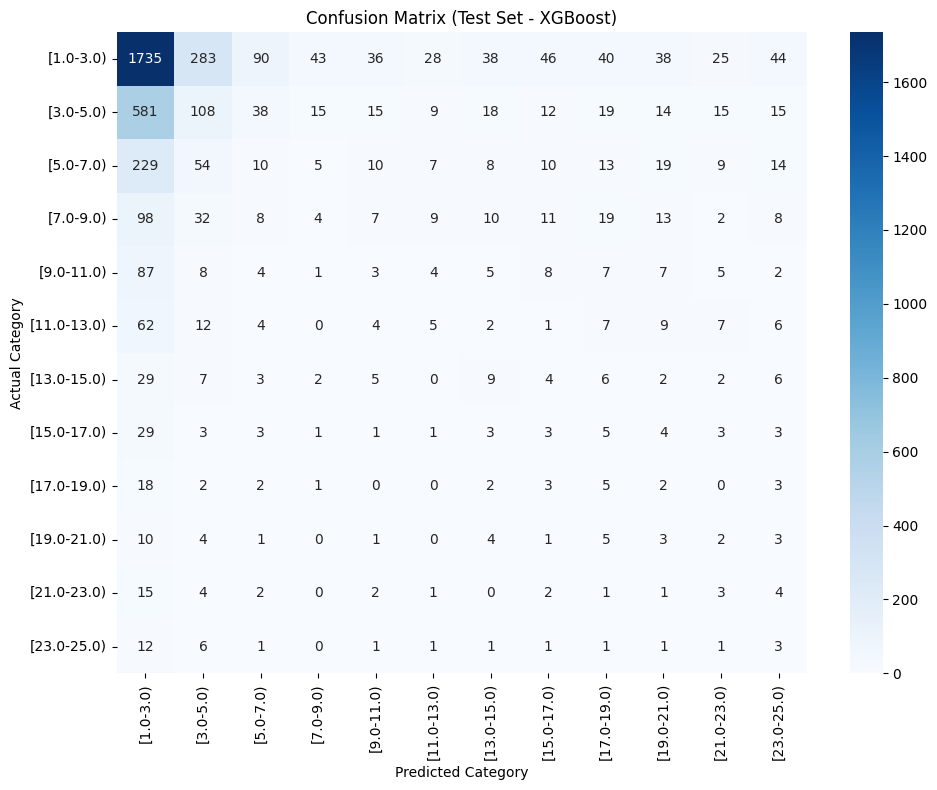

<Figure size 960x600 with 0 Axes>

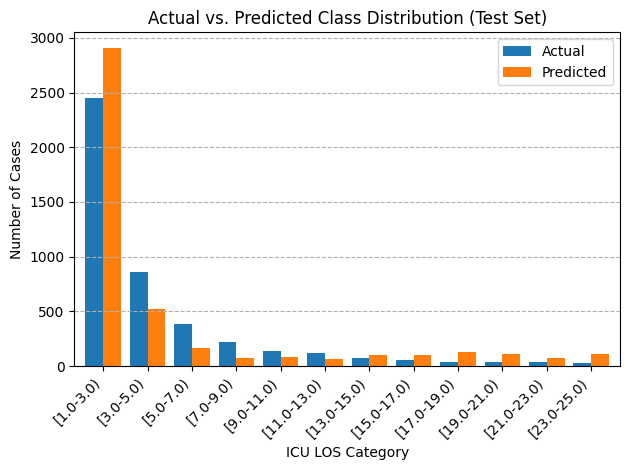


Execution time: 2.44 seconds


In [68]:
# --- Record Start Time ---
start_time = time.time()
print("\n--- Block 4: Evaluating and Visualizing Results ---")

# Check if necessary data for evaluation is available
if ('y_val_cat' not in globals() or
    'y_test_cat' not in globals() or
    'y_pred_val_final' not in globals() or
    'y_pred_test_final' not in globals() or
    'num_classes' not in globals()):
    print("Necessary data for evaluation/visualization is missing. Skipping.")
else:
    # Define descriptive labels for your bins for plotting
    bin_labels_for_plots = []
    if 'WINDOW_DAYS' in globals() and 'BIN_WIDTH' in globals() and num_classes > 0 :
         for i in range(num_classes):
            lower_bound = WINDOW_DAYS + i * BIN_WIDTH
            upper_bound = WINDOW_DAYS + (i + 1) * BIN_WIDTH
            bin_labels_for_plots.append(f"[{lower_bound:.1f}-{upper_bound:.1f})")
    else: # Fallback labels
        bin_labels_for_plots = [f"Cat {i}" for i in range(num_classes)]

    print(f"Using bin labels for plots: {bin_labels_for_plots}")


    # --- 1. Evaluate the Model ---
    # Validation Set Metrics (if y_val_cat and y_pred_val_final are not empty)
    if not y_val_cat.empty and not y_pred_val_final.empty:
        # Ensure labels in classification report and confusion matrix cover all possible classes
        unique_labels_present_val = np.union1d(y_val_cat.unique(), y_pred_val_final.unique())
        # Ensure all labels from 0 to num_classes-1 are considered for consistency if some classes have 0 instances
        report_labels_val = list(range(num_classes))

        accuracy_val = accuracy_score(y_val_cat, y_pred_val_final)
        kappa_val = cohen_kappa_score(y_val_cat, y_pred_val_final, labels=report_labels_val if report_labels_val else None)
        report_val = classification_report(y_val_cat, y_pred_val_final, labels=report_labels_val, target_names=bin_labels_for_plots, zero_division=0)

        print("\n--- Validation Set Metrics (XGBoost - Categorical) ---")
        print(f"Accuracy: {accuracy_val:.3f}")
        print(f"Cohen's Kappa: {kappa_val:.3f}")
        print("Classification Report (Validation):\n", report_val)
    else:
        print("\nValidation data (actual or predicted) is empty. Skipping validation metrics.")

    # Test Set Metrics (if y_test_cat and y_pred_test_final are not empty)
    if not y_test_cat.empty and not y_pred_test_final.empty:
        unique_labels_present_test = np.union1d(y_test_cat.unique(), y_pred_test_final.unique())
        report_labels_test = list(range(num_classes))

        accuracy_test = accuracy_score(y_test_cat, y_pred_test_final)
        kappa_test = cohen_kappa_score(y_test_cat, y_pred_test_final, labels=report_labels_test if report_labels_test else None)
        report_test = classification_report(y_test_cat, y_pred_test_final, labels=report_labels_test, target_names=bin_labels_for_plots, zero_division=0)
        cm_test = confusion_matrix(y_test_cat, y_pred_test_final, labels=report_labels_test)

        print("\n--- Test Set Metrics (XGBoost - Categorical) ---")
        print(f"Accuracy: {accuracy_test:.3f}")
        print(f"Cohen's Kappa: {kappa_test:.3f}")
        print("Classification Report (Test):\n", report_test)
        # print("Confusion Matrix (Test):\n", cm_test)

        # --- 2. Visualize Results (Test Set) ---
        # a) Confusion Matrix Heatmap
        if num_classes > 0:
            plt.figure(figsize=(min(10, num_classes + 2), min(8, num_classes + 1)))
            sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                        xticklabels=bin_labels_for_plots,
                        yticklabels=bin_labels_for_plots)
            plt.xlabel("Predicted Category")
            plt.ylabel("Actual Category")
            plt.title("Confusion Matrix (Test Set - XGBoost)")
            plt.tight_layout()
            plt.show()

            # b) Actual vs. Predicted Class Distribution
            plt.figure(figsize=(max(8, num_classes * 0.8), 6))
            actual_counts = y_test_cat.value_counts().reindex(range(num_classes), fill_value=0).sort_index()
            predicted_counts = y_pred_test_final.value_counts().reindex(range(num_classes), fill_value=0).sort_index()

            df_counts = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})
            if not df_counts.empty:
                # Use the generated bin_labels_for_plots for the x-axis ticks
                df_counts.index = [bin_labels_for_plots[i] for i in df_counts.index if i < len(bin_labels_for_plots)]

                df_counts.plot(kind='bar', width=0.8)
                plt.title("Actual vs. Predicted Class Distribution (Test Set)")
                plt.xlabel("ICU LOS Category")
                plt.ylabel("Number of Cases")
                plt.xticks(rotation=45, ha="right")
                plt.legend()
                plt.grid(axis='y', linestyle='--')
                plt.tight_layout()
                plt.show()
            else:
                print("Cannot plot class distribution: Counts data is empty.")
        else:
            print("Number of classes is 0, cannot generate plots.")
    else:
        print("\nTest data (actual or predicted) is empty. Skipping test metrics and visualization.")


# --- Record End Time ---
end_time = time.time()
execution_time = end_time - start_time
print(f"\nExecution time: {execution_time:.2f} seconds")


# **Final Conclusions**

### **Features Distribution**
We were able to get some interesting conclusions from the distribution analysis for each feature, namely:
- Most of patients only stay in ICU for `5 days or less`, with a decreasing trend of the number of patients as the number of days increases.

### **Features Correlation**
We were also able to draw interesting conclusions from the correlation between different features, namely:
- The correlation between `Diagnosis` and `ICU Length of Stay` is evident, with `Twin mate, liveborn, delivered in hospital, with cesarean section` having a much higher mean value compared to other types of Diagnosis
- Regarding the connection between `Age` and `Length of ICU Stay`, we can conclude that the vast majority of ICU stays are relatively short across all adult age groups, although the spread of the values of `Length of ICU Stay` appears to widen slightly for older patients
- All `Insurance` systems have a similar distribution and mean for `ICU Length of Stay`, with a clear exception of `Self Pay`, whose average value is significantly lower.
-	Patients who have `EMERGENCY` as their `Type of Admission` tend to `EXPIRE`(die) much more frequently.
-	`NICU (Neonatal Intensive Care Unit)` has the lowest number of deaths and `MICU (Medical Intensive Care Unit)` has the highest number of deaths.

### **Predictor Model**
- The `accuracy` value in the `Validation` and in `Testing` set are similar and have medium-low values, which mean the model wasn't very sucessful at predicting the patients `ICU Length of Stay` during the validation phase
- The `Cohen's Kappa` value for both `Validation` and `Testing` is very low, which indicates the model is not much better than a random chance model at predicting the correct classes
- The `heatmap` shows that the model is very good at predicting correctly the majority class [1-3] days, but mostly fails at predicting other classes correctly
- The `bar plot` shows that the model predictions distribution is pretty similar to the actual data distribution, which is a good sign for possible future improvements
- In summary, the predictions for the majority class are accurate but for minority classes are not, which is a very common problem in Machine Learning prediction models.
- In future works, we could try to improve these bad results by performing better `feature engineering`, performing `fine-tuning` in the parameters of the predictor model, choose more wisely the features to use and possibly choose a more adequate model for the dataset.

### **BigQuery and Execution Time**
- The BigQuery proved to be a reliable and intuitive platform to perform `Machine Learning` projects
- The queries that were timed (not all were because all the results would be very similar) executed almost instantly (range from < 1 second to ~3/4 seconds)
- All the steps for executing the `XGBoost Classifier` model were also (and surprisingly!) very fast, with all executions running almost instantly

### **Dask and Execution Time**
- Dask can support very large datasets while maintaining very quick and efficient processing speeds.
- However, because of the way we treated the data, we weren't able to see many improvements when compared to other libraries like Pandas, with most executions ranging from 2~40 seconds.

### Project Developed by:
- Francisco Macieira → up202207166@edu.fc.up.pt
- Manuel Silva → up202108874@edu.fe.up.pt
- Nuno Gomes → up202206195@edu.fc.up.pt